In [1]:
import scanpy as sc
#import gseapy as gs
import numpy as np
import scipy as sp
from scipy.stats import spearmanr, pearsonr

import pandas as pd

In [51]:
# Importing plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
from matplotlib import cm
from heatmap import heatmap

In [3]:
# Import support vector model
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import plot_tree, export_graphviz
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix

In [4]:
import sklearn
sklearn.__version__

'0.22.1'

In [5]:
# Scanpy settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

master_dir = '../'

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.8.2 louvain==0.7.0 leidenalg==0.8.1


In [6]:
# Get the treatment information per patient
pt_obs = pd.read_csv(master_dir + 'data/observations_2020-09-04_1027-cleaned-withTxInfo.tsv',
                    sep=',', header=0)
pt_obs.head(10)

source_label                        observation_id incov_redcap_event_name  \
0     INCOV001  0136c6b6-5c01-42ca-a1ea-d1286f193041                      T1   
1     INCOV001  d372353b-edf7-4d01-adc9-567603c30bc7                      T2   
2     INCOV002  7403b5ac-6810-431e-bc21-f39a81edbf27                      T1   
3     INCOV002  b21d9bf4-07cf-4d0d-9638-0e02f739f989                      T2   
4     INCOV003  04e24104-e195-4a32-85e7-bdc935800f4a                      T1   
5     INCOV003  d95c1823-a2e6-4bc7-ab74-695d3bd60d8a                      T2   
6     INCOV004  3f8ad391-7e1b-44d4-9e20-bc1c47f92ed7                      T1   
7     INCOV004  7aa62005-e2ce-4dde-8aa2-c2cf78780725                      T2   
8     INCOV005  483d6ac3-f06b-4b53-be23-15af57c43bf2                      T1   
9     INCOV005  6894c9cc-f011-41ae-a818-3d14814bbd6d                      T2   

   observation_days_since_enrollment abdominal_pain                ambulatory  \
0                               0.92             No  Limitation of activities   
1                               5.92             No  Limitation of activities   
2                               0.71             No  Limitation of activities   
3                               5.75        Unknown  Limitation of activities   
4                               0.54        Unknown  Limitation of activities   
5                               7.38        Unknown  Limitation of activities   
6                               0.75             No  Limitation of activities   
7                               5.75             No  Limitation of activities   
8                               0.00             No  Limitation of activities   
9                               3.75             No  Limitation of activities   

  blood_draw_status                              blood_draw_status_bad  \
0          Complete                                                NaN   
1          Complete                                                NaN   
2          Complete                                                NaN   
3          Complete                                                NaN   
4          Complete                                                NaN   
5        Incomplete  Reduced Blood Draw at the request of LAR - 8/1...   
6          Complete                                                NaN   
7          Complete                                                NaN   
8          Complete                                                NaN   
9          Complete                                                NaN   

  blood_draw_type  blood_oxygenation  ...  patient_num  \
0        Baseline               95.0  ...          1-1   
1           Acute               96.0  ...          1-2   
2        Baseline               96.0  ...          2-1   
3           Acute               91.0  ...          2-2   
4        Baseline               96.0  ...          3-1   
5           Acute               94.0  ...          3-2   
6        Baseline               98.0  ...          4-1   
7           Acute               95.0  ...          4-2   
8        Baseline               93.0  ...          5-1   
9           Acute               91.0  ...          5-2   

   time_wrt_Remdesivir (RDV) time_wrt_Tocilizumab time_wrt_Vitamin C  \
0                     Before                No.T1              No.T1   
1                      After                No.T2              No.T2   
2                     Before               Before             Before   
3                      After                After              After   
4                     Before               Before             Before   
5                      After                After              After   
6                     Before                No.T1              No.T1   
7                      After                No.T2              No.T2   
8                     Before               Before             Before   
9                      After                After      

In [7]:
# Classify patients into groups:
# 1. treatment/no treatment with a specific medication
# 2. improved/worsened/stable per WHO scale
# Main identifier is patient_num
#
# Treatments:
# RDV
# Tocilizumab
# Vit C
# Zn
# HCQ
# HCQ + azithromycin
# Steroid
# Other
# Plasma transfusion
# Change in condition is the difference in WHO scale in timepoint 2 vs. 1
# Qualitative change (better, worse, stable) is not very well received by the SVM

pt_obs.index = pt_obs['source_label']
pt_obs['who_ordinal_scale'] = pt_obs['who_ordinal_scale'].apply(lambda v: 1 if v=='<=2' \
                                                                else (1.5 if v=='1 or 2' else v))

list_tx = ['Remdesivir (RDV)', 'Tocilizumab', 'Vitamin C', 'Zinc', 'Hydroxychloroquine (HCQ)',
          'HCQ + Azithromycin', 'Steroid', 'Other', 'Plasma Transfusions']
#for tx in list_tx:
#    pt_obs['tx_result_wrt_' + tx] = pd.Series()

pt_obs = pt_obs.dropna(axis=0, subset=['who_ordinal_scale'])

for source in pt_obs['source_label'].unique():
    pt = pt_obs.loc[pt_obs['source_label']==source]
    for tx in list_tx:
        time_wrt = 'time_wrt_' + tx
        if len(pt) < 2:
            # If only one observation, omit
            pt.loc[:, 'tx_result_wrt_' + tx] = 'Unknown'
        elif pt[time_wrt][0]=='Before' and pt[time_wrt][1]=='After':
            change = int(pt['who_ordinal_scale'][1]) - int(pt['who_ordinal_scale'][0])
            pt_obs.loc[source, 'tx_result_wrt_' + tx] = change
        elif pt[time_wrt][0]=='No.T1' and pt[time_wrt][1]=='No.T2': # If the patient was not treated with this at all
            try:
                change = int(pt['who_ordinal_scale'][1]) - int(pt['who_ordinal_scale'][0])
                pt_obs.loc[source, 'tx_result_wrt_' + tx] = change + 200
            except:
                pt_obs.loc[source, 'tx_result_wrt_' + tx] = 'Unknown'
        else:
            pt_obs.loc[source, 'tx_result_wrt_' + tx] = 'Unknown'
            
    # Also a general column disregarding treatments
    if len(pt) < 2:
        continue
    elif pt['incov_redcap_event_name'][0]=='T1' and pt['incov_redcap_event_name'][1]=='T2':
        pt_obs.loc[source, 'tx_result_wrt_general'] = \
            int(pt['who_ordinal_scale'][1]) - int(pt['who_ordinal_scale'][0])
        
    # Also a general column that just has the score
    if len(pt) < 2:
        continue
    elif pt['incov_redcap_event_name'][0]=='T1' and pt['incov_redcap_event_name'][1]=='T2':
        pt_obs.loc[source, 'tx_result_wrt_general_noDiff'] = \
            int(pt['who_ordinal_scale'][0])
            
pt_obs.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


source_label                        observation_id  \
source_label                                                      
INCOV001         INCOV001  0136c6b6-5c01-42ca-a1ea-d1286f193041   
INCOV001         INCOV001  d372353b-edf7-4d01-adc9-567603c30bc7   
INCOV002         INCOV002  7403b5ac-6810-431e-bc21-f39a81edbf27   
INCOV002         INCOV002  b21d9bf4-07cf-4d0d-9638-0e02f739f989   
INCOV003         INCOV003  04e24104-e195-4a32-85e7-bdc935800f4a   

             incov_redcap_event_name  observation_days_since_enrollment  \
source_label                                                              
INCOV001                          T1                               0.92   
INCOV001                          T2                               5.92   
INCOV002                          T1                               0.71   
INCOV002                          T2                               5.75   
INCOV003                          T1                               0.54   

             abdominal_pain                ambulatory blood_draw_status  \
source_label                                                              
INCOV001                 No  Limitation of activities          Complete   
INCOV001                 No  Limitation of activities          Complete   
INCOV002                 No  Limitation of activities          Complete   
INCOV002            Unknown  Limitation of activities          Complete   
INCOV003            Unknown  Limitation of activities          Complete   

             blood_draw_status_bad blood_draw_type  blood_oxygenation  ...  \
source_label                                                           ...   
INCOV001                       NaN        Baseline               95.0  ...   
INCOV001                       NaN           Acute               96.0  ...   
INCOV002                       NaN        Baseline               96.0  ...   
INCOV002                       NaN           Acute               91.0  ...   
INCOV003                       NaN        Baseline               96.0  ...   

              tx_result_wrt_Tocilizumab  tx_result_wrt_Vitamin C  \
source_label                                                       
INCOV001                            200                      200   
INCOV001                            200                      200   
INCOV002                              2                        2   
INCOV002                              2                        2   
INCOV003                             -1                       -1   

             tx_result_wrt_Zinc tx_result_wrt_Hydroxychloroquine (HCQ)  \
source_label                                                             
INCOV001                    200                                    200   
INCOV001                    200                                    200   
INCOV002                      2                                      2   
INCOV002                      2                                      2   
INCOV003                    199                                     -1   

             tx_result_wrt_HCQ + Azithromycin  tx_result_wrt_Steroid  \
source_label                                                           
INCOV001                                  200                    200   
INCOV001                                  200                    200   
INCOV002                                  202                    202   
INCOV002                                  202                    202   
INCOV003                                  199                    199   

             tx_result_wrt_Other tx_result_wrt_Plasma Transfusions  \
source_label                                                         
INCOV001                     200                               200   
INCOV001                     200                               200   
INCOV002                     202                               202   
INCOV002                     202                               202   
INCOV003               

In [8]:
pt_obs['patient_num']

source_label
INCOV001      1-1
INCOV001      1-2
INCOV002      2-1
INCOV002      2-2
INCOV003      3-1
            ...  
INCOV162    162-1
INCOV162    162-2
INCOV163    163-1
INCOV163    163-2
INCOV165    165-1
Name: patient_num, Length: 300, dtype: object

In [9]:
pt_obs['sample_id'] = pt_obs['source_label'] + \
            pt_obs['blood_draw_type'].map({'Baseline': '-BL', 'Acute': '-AC', 'Convalescent': '-CV',
                                               'Other (e.g. Discretionary)': '-PD1'})
pt_mapper = pt_obs.loc[:, ['sample_id', 'patient_num']]
pt_mapper.head()

sample_id patient_num
source_label                         
INCOV001      INCOV001-BL         1-1
INCOV001      INCOV001-AC         1-2
INCOV002      INCOV002-BL         2-1
INCOV002      INCOV002-AC         2-2
INCOV003      INCOV003-BL         3-1

## Metabolites as a predictor of treatment response

In [10]:
# Get the metabolites
metabolites = pd.read_csv(master_dir + 'output/all-metabolites-concentrations-data_200905.csv')
metabolites.index = metabolites['sample_id']
metabolites_only = pd.merge(metabolites, pt_mapper, left_index=True, right_on='sample_id')
metabolites_only.index = metabolites_only['patient_num']
metabolites_only = metabolites_only.drop(columns=['sample_id', 'sample_id_x', 'sample_id_y', 'patient_num'])
metabolites_only.head()

S-1-pyrroline-5-carboxylate  spermidine  1-methylnicotinamide  \
patient_num                                                                  
78-1                            0.995968    1.674232              0.506166   
108-1                           1.041911    1.654157              0.595064   
77-2                            1.457850    3.534459              0.588998   
78-2                            0.000000    1.390880              0.357924   
77-1                            1.094441    3.850411              2.503983   

             12,13-DiHOME  5-hydroxyindoleacetate  alpha-ketoglutarate  \
patient_num                                                              
78-1             1.744064                1.099204             1.285387   
108-1            0.919324                0.000000             1.434180   
77-2             0.806660                0.000000             1.090338   
78-2             1.365795                0.610623             1.129522   
77-1             0.904575                1.291502             1.806803   

             kynurenate  3-hydroxyisobutyrate  3-hydroxy-3-methylglutarate  \
patient_num                                                                  
78-1           0.417741              0.591977                     0.938908   
108-1          0.607484              1.765214                     1.592605   
77-2           0.636252              0.690626                     2.470723   
78-2           0.810225              0.445462                     0.989685   
77-1           1.297075              1.588095                     1.568453   

             homovanillate (HVA)  ...  \
patient_num                       ...   
78-1                    1.080404  ...   
108-1                   0.816428  ...   
77-2                    0.869807  ...   
78-2                    1.288852  ...   
77-1                    1.212143  ...   

             bilirubin degradation product, C16H18N2O5 (2)**  \
patient_num                                                    
78-1                                                0.852283   
108-1                                               0.672256   
77-2                                                0.818123   
78-2                                                1.093358   
77-1                                                1.638320   

             bilirubin degradation product, C17H18N2O4 (1)**  \
patient_num                                                    
78-1                                                0.979086   
108-1                                               0.782379   
77-2                                                1.024852   
78-2                                                0.879875   
77-1                                                1.431864   

             bilirubin degradation product, C17H18N2O4 (2)**  \
patient_num                                                    
78-1                                                0.953791   
108-1                                               0.725400   
77-2                                                0.958672   
78-2                                                0.922083   
77-1                                                1.389025   

             bilirubin degradation product, C17H18N2O4 (3)**  \
patient_num                                                    
78-1                                                1.020159   
108-1                                               0.750352   
77-2                                                0.964862   
78-2                                                1.010511   
77-1                                                1.422175   

             bilirubin degradation product, C17H20N2O5 (1)**  \
patient_num                                                    
78-1                                                0.985949   
108-1                                               0.350729   
77-2                                                1.001729

In [11]:
pt_obs.index = pt_obs['patient_num']
pt_obs_metabolites = pd.merge(pt_obs, metabolites_only, left_index=True, right_index=True, how='inner')
pt_obs_metabolites = pt_obs_metabolites.sort_values(by=['source_label', 'incov_redcap_event_name'], 
                                                   ascending=[True, True])
pt_obs_metabolites.head()

source_label                        observation_id  \
patient_num                                                      
1-1             INCOV001  0136c6b6-5c01-42ca-a1ea-d1286f193041   
1-2             INCOV001  d372353b-edf7-4d01-adc9-567603c30bc7   
2-1             INCOV002  7403b5ac-6810-431e-bc21-f39a81edbf27   
2-2             INCOV002  b21d9bf4-07cf-4d0d-9638-0e02f739f989   
3-1             INCOV003  04e24104-e195-4a32-85e7-bdc935800f4a   

            incov_redcap_event_name  observation_days_since_enrollment  \
patient_num                                                              
1-1                              T1                               0.92   
1-2                              T2                               5.92   
2-1                              T1                               0.71   
2-2                              T2                               5.75   
3-1                              T1                               0.54   

            abdominal_pain                ambulatory blood_draw_status  \
patient_num                                                              
1-1                     No  Limitation of activities          Complete   
1-2                     No  Limitation of activities          Complete   
2-1                     No  Limitation of activities          Complete   
2-2                Unknown  Limitation of activities          Complete   
3-1                Unknown  Limitation of activities          Complete   

            blood_draw_status_bad blood_draw_type  blood_oxygenation  ...  \
patient_num                                                           ...   
1-1                           NaN        Baseline               95.0  ...   
1-2                           NaN           Acute               96.0  ...   
2-1                           NaN        Baseline               96.0  ...   
2-2                           NaN           Acute               91.0  ...   
3-1                           NaN        Baseline               96.0  ...   

             bilirubin degradation product, C16H18N2O5 (2)**  \
patient_num                                                    
1-1                                                 1.446093   
1-2                                                 1.278922   
2-1                                                 0.385904   
2-2                                                 0.453962   
3-1                                                 0.588534   

             bilirubin degradation product, C17H18N2O4 (1)**  \
patient_num                                                    
1-1                                                 1.830923   
1-2                                                 1.498499   
2-1                                                 0.194710   
2-2                                                 0.459911   
3-1                                                 0.356317   

            bilirubin degradation product, C17H18N2O4 (2)**  \
patient_num                                                   
1-1                                                1.845439   
1-2                                                1.656242   
2-1                                                0.176604   
2-2                                                0.549555   
3-1                                                0.403319   

            bilirubin degradation product, C17H18N2O4 (3)**  \
patient_num                                                   
1-1                                                1.369932   
1-2                                                1.207441   
2-1                                                0.236984   
2-2                                                0.493202   
3-1                                                0.324699   

            bilirubin degradation product, C17H20N2O5 (1)**  \
patient_num                                                   
1-1                                                1.617032   


In [12]:
# Just the metabolites and clinical info from before tx
# Delete all columns that are not relevant for a predictive model
pt_obs_metabolites_pre = pt_obs_metabolites.groupby('source_label').first()
#pt_obs_metabolites_pre_relevant = pt_obs_metabolites_pre.drop(columns=['observation_id', 
#           'incov_redcap_event_name', 'blood_draw_status', 'blood_draw_status_bad', 
#           'blood_draw_type', 'blood_oxygenation_max', 
#           'blood_oxygenation_min', 'patient_location', 'temperature_max', 'temperature_min', 'patient_num',
#           'time_wrt_Remdesivir (RDV)', 'time_wrt_Tocilizumab',
#           'time_wrt_Vitamin C', 'time_wrt_Zinc',
#           'time_wrt_Hydroxychloroquine (HCQ)', 'time_wrt_HCQ + Azithromycin',
#           'time_wrt_Steroid', 'time_wrt_Other', 'time_wrt_Plasma Transfusions',
#           'tx_result_wrt_Remdesivir (RDV)', 'tx_result_wrt_Tocilizumab',
#           'tx_result_wrt_Vitamin C', 'tx_result_wrt_Zinc',
#           'tx_result_wrt_Hydroxychloroquine (HCQ)',
#           'tx_result_wrt_HCQ + Azithromycin', 'tx_result_wrt_Steroid',
#           'tx_result_wrt_Other', 'tx_result_wrt_Plasma Transfusions'])
# Try dropping everything except metabolites
pt_obs_metabolites_pre_relevant = pt_obs_metabolites_pre.iloc[:, -1050:]
# Initial WHO ordinal scale as another part of the prediction
pt_obs_metabolites_pre_relevant['who_ordinal_scale'] = pt_obs_metabolites_pre['who_ordinal_scale']
pt_obs_metabolites_pre_relevant['observation_days_since_enrollment'] = pt_obs_metabolites_pre['observation_days_since_enrollment']
pt_obs_metabolites_pre_relevant.head()

S-1-pyrroline-5-carboxylate  spermidine  1-methylnicotinamide  \
source_label                                                                  
INCOV001                         0.000000    1.069591              0.403287   
INCOV002                         0.000000    0.686773              2.276374   
INCOV003                         0.586063    1.193088              0.611347   
INCOV004                         0.839983    0.454993              0.958646   
INCOV005                         0.638417    1.905690              0.597451   

              12,13-DiHOME  5-hydroxyindoleacetate  alpha-ketoglutarate  \
source_label                                                              
INCOV001          0.680598                0.875862             1.435992   
INCOV002          1.193626                0.461479             0.654987   
INCOV003          4.529727                0.660536             0.709994   
INCOV004          0.278097                0.221124             1.411163   
INCOV005          0.562761                0.580341             1.441302   

              kynurenate  3-hydroxyisobutyrate  3-hydroxy-3-methylglutarate  \
source_label                                                                  
INCOV001        1.810513              1.441880                     1.603509   
INCOV002        1.005636              1.819546                     0.758031   
INCOV003        1.376158              3.385082                     1.694633   
INCOV004        1.437406              1.729549                     1.904780   
INCOV005        1.129063              0.000000                     1.279133   

              homovanillate (HVA)  ...  \
source_label                       ...   
INCOV001                 2.173915  ...   
INCOV002                 1.083165  ...   
INCOV003                 0.000000  ...   
INCOV004                 0.966603  ...   
INCOV005                 0.632811  ...   

              bilirubin degradation product, C17H18N2O4 (2)**  \
source_label                                                    
INCOV001                                             1.845439   
INCOV002                                             0.176604   
INCOV003                                             0.403319   
INCOV004                                             0.341907   
INCOV005                                             1.828274   

              bilirubin degradation product, C17H18N2O4 (3)**  \
source_label                                                    
INCOV001                                             1.369932   
INCOV002                                             0.236984   
INCOV003                                             0.324699   
INCOV004                                             0.316786   
INCOV005                                             1.722344   

              bilirubin degradation product, C17H20N2O5 (1)**  \
source_label                                                    
INCOV001                                             1.617032   
INCOV002                                             0.143750   
INCOV003                                             0.273638   
INCOV004                                             0.200395   
INCOV005                                             1.641054   

              bilirubin degradation product, C17H20N2O5 (2)**  \
source_label                                                    
INCOV001                                             1.673842   
INCOV002                                             0.143877   
INCOV003                                             0.296769   
INCOV004                                             0.253856   
INCOV005                                             1.919129   

              tetrahydrocortisol glucuronide  N,N-dimethyl-pro-pro  \
source_label                                                         
INCOV001                            1.565146              3.380593   
INCOV002                            0.745335       

In [13]:
pt_obs_metabolites_pre['incov_redcap_event_name'].unique()

array(['T1'], dtype=object)

In [14]:
pt_obs_metabolites_pre_relevant

S-1-pyrroline-5-carboxylate  spermidine  1-methylnicotinamide  \
source_label                                                                  
INCOV001                         0.000000    1.069591              0.403287   
INCOV002                         0.000000    0.686773              2.276374   
INCOV003                         0.586063    1.193088              0.611347   
INCOV004                         0.839983    0.454993              0.958646   
INCOV005                         0.638417    1.905690              0.597451   
...                                   ...         ...                   ...   
INCOV135                         0.209067    1.023370              2.515001   
INCOV136                         0.723258    2.292971              0.650270   
INCOV137                         1.064520    1.608219              1.162249   
INCOV139                         1.682527    3.975026              0.461765   
INCOV142                         0.669127    3.854680              1.596399   

              12,13-DiHOME  5-hydroxyindoleacetate  alpha-ketoglutarate  \
source_label                                                              
INCOV001          0.680598                0.875862             1.435992   
INCOV002          1.193626                0.461479             0.654987   
INCOV003          4.529727                0.660536             0.709994   
INCOV004          0.278097                0.221124             1.411163   
INCOV005          0.562761                0.580341             1.441302   
...                    ...                     ...                  ...   
INCOV135          0.000000                0.000000             1.014864   
INCOV136          0.000000                0.000000             0.730180   
INCOV137          0.000000                0.000000             0.532503   
INCOV139          3.031450                3.421115             1.308867   
INCOV142          0.000000                0.000000             0.599414   

              kynurenate  3-hydroxyisobutyrate  3-hydroxy-3-methylglutarate  \
source_label                                                                  
INCOV001        1.810513              1.441880                     1.603509   
INCOV002        1.005636              1.819546                     0.758031   
INCOV003        1.376158              3.385082                     1.694633   
INCOV004        1.437406              1.729549                     1.904780   
INCOV005        1.129063              0.000000                     1.279133   
...                  ...                   ...                          ...   
INCOV135        1.454637              1.777383                     1.033163   
INCOV136        0.562968              2.151784                     1.273243   
INCOV137        3.475657              1.948331                     1.580821   
INCOV139        1.089875              1.975403                     2.349692   
INCOV142        2.081112              3.013365                     1.348497   

              homovanillate (HVA)  ...  \
source_label                       ...   
INCOV001                 2.173915  ...   
INCOV002                 1.083165  ...   
INCOV003                 0.000000  ...   
INCOV004                 0.966603  ...   
INCOV005                 0.632811  ...   
...                           ...  ...   
INCOV135                 0.872491  ...   
INCOV136                 0.000000  ...   
INCOV137                 0.673008  ...   
INCOV139                 2.334259  ...   
INCOV142                 0.000000  ...   

              bilirubin degradation product, C17H18N2O4 (2)**  \
source_label                                                    
INCOV001                                             1.845439   
INCOV002                                             0.176604   
INCOV003                                             0.403319   
INCOV004                                             0.341907   
INCOV005                                     

In [15]:
pt_obs_metabolites_pre_relevant = pt_obs_metabolites_pre_relevant.dropna(axis=1)

In [16]:
pt_obs_metabolites_pre_relevant = pt_obs_metabolites_pre_relevant.astype(float)

In [17]:
# Preselect variables by PCA
# Select top 100
pca = PCA(n_components=2).fit(pt_obs_metabolites_pre_relevant)

variability = pd.DataFrame(np.sum(abs(pca.components_), axis=0).transpose())
pt_obs_metabolites_pre_variable = pt_obs_metabolites_pre_relevant.iloc[:, 
                                    variability.sort_values(by=0, ascending=False).index[:700]]
pt_obs_metabolites_pre_variable.columns

Index(['N-acetyltryptophan', '4-acetamidophenylglucuronide',
       '4-acetaminophen sulfate', '3-hydroxysebacate', 'orotidine',
       '2-hydroxyacetaminophen sulfate*',
       '3-(N-acetyl-L-cystein-S-yl) acetaminophen', 'L-urobilin',
       'glutamine conjugate of C7H12O2*', '4-acetamidophenol',
       ...
       'stearoyl sphingomyelin (d18:1/18:0)', '1-docosahexaenoyl-GPE (22:6)*',
       '1-stearoyl-2-oleoyl-GPE (18:0/18:1)', 'glucuronide of C19H28O4 (2)*',
       'S-methylcysteine sulfoxide', 'bilirubin (Z,Z)', 'oleoylcholine',
       '2-hydroxystearate', 'linoleoyl-arachidonoyl-glycerol (18:2/20:4) [1]*',
       '1-palmitoyl-2-adrenoyl-GPC (16:0/22:4)*'],
      dtype='object', length=700)

In [105]:
# Support vector machines
# HCQ-only has no before-after comparisons, so we will omit this
tx_clfs = []
test_results = []

class train_test:
    # For storing the machine, training set, testing set, and prediction
    def __init__(self, pre_clf, selected_features, clf, 
                 X_train, X_test, y_train, y_test, prediction, score):
        self.pre_clf = pre_clf
        self.selected_features = selected_features
        self.clf = clf
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.prediction = prediction
        self.score = score

list_tx_general = ['Remdesivir (RDV)', 'Tocilizumab', 'general', 'general_noDiff']
for tx in list_tx_general:
    
    # Does not work well
    #scorer = make_scorer(mean_squared_error, greater_is_better=False)
    #tx_clfs.append(Pipeline([('scaler', StandardScaler()), 
    #                        ('rfe_svr', RFECV(SVR(kernel='linear'), min_features_to_select=1, 
    #                                           step=1, cv=3, 
    #                                           scoring=scorer, n_jobs=-1) )]))
    
    tx_clfs.append(Pipeline([('scaler', StandardScaler()),
                            ('randomForest', RandomForestClassifier(n_estimators=500, oob_score=True,
                                                                    max_depth=20, random_state=0, n_jobs=-1)) ]))
    
    # Does not work well
    #scorer = make_scorer(mean_squared_error, greater_is_better=False)
    #parameters = [{'kernel': ['rbf'], 'gamma': [1e-5, 1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9, 0.99],
    #               'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}]
    #svr_gs = GridSearchCV(SVR(epsilon = 1), parameters, cv=4, scoring=scorer)    
    #tx_clfs.append(Pipeline([('scaler', StandardScaler()), 
    #                         ('svr', svr_gs)]))
    
    # Does not work well
    #tx_clfs.append(Pipeline([('scaler', StandardScaler()), 
    #                         ('rfe_svr', RFECV(SVC(kernel='linear'), min_features_to_select=2, 
    #                                           step=1, cv=5, 
    #                                           scoring='accuracy', n_jobs=-1) )]))
    
    # https://scikit-learn.org/stable/modules/model_evaluation.html 
    # --> choose one of the regression scoring metrics

for i, tx in enumerate(list_tx_general):
    col = 'tx_result_wrt_' + tx
    # HCQ-only has no before-after comparisons, so we will omit this
    # HCQ+azithro has only one before-after comparisons, so we will omit this
    # Vitamin C and Zinc currently have too few samples to make a good model
    if tx=='Hydroxychloroquine (HCQ)' or tx=='HCQ + Azithromycin' or tx=='Steroid' \
        or tx=='Other' or tx=='Plasma Transfusions' or tx=='Vitamin C' or tx=='Zinc':
        print(tx + ' has not enough comparisons')
        continue
    print(col)
    
    temp = pt_obs_metabolites_pre[pt_obs_metabolites_pre[col]!='Unknown'][col]
    treated_output = temp[temp < 100].astype(float)
    # Classification version of outcomes
    #treated_output_discrete = treated_output.apply(lambda v: -100 if v < 0 else (100 if v > 0 else 0))
    
    treated_input = pt_obs_metabolites_pre_relevant.loc[treated_output.index].astype(float)
    if tx=='general_noDiff':
        try:
            treated_input = treated_input.drop(columns=['who_ordinal_scale'])
        except:
            a = 1
    
    # Tree-based feature selection
    pre_clf = ExtraTreesClassifier(n_estimators=500, criterion='gini', n_jobs=-1, random_state=0)
    pre_clf = pre_clf.fit(treated_input, treated_output)
    importances = pre_clf.feature_importances_
    model = SelectFromModel(pre_clf, threshold='3.5*mean', prefit=True)
    selected_features = treated_input.columns[model.get_support(indices=True)]
    treated_input = model.transform(treated_input)
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(treated_input, 
                                                                    treated_output, 
                                                                    test_size=0.25, random_state=0)
    
    tx_clfs[i].fit(X_train, y_train)
    
    test_results.append(train_test(pre_clf, selected_features, tx_clfs[i], X_train, X_test, y_train, y_test, 
                                  tx_clfs[i].predict(X_test), tx_clfs[i].score(X_test, y_test)))
    
# Also try prognosis regardless of interventions
temp = pt_obs_metabolites_pre

tx_result_wrt_Remdesivir (RDV)
tx_result_wrt_Tocilizumab
tx_result_wrt_general


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


tx_result_wrt_general_noDiff


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [106]:
# For random forest classifier: this is the mean accuracy on the given test data and labels
# This is exact accuracy
test_results[0].score, test_results[1].score, test_results[2].score, test_results[3].score

(0.5833333333333334, 0.8, 0.6129032258064516, 0.45161290322580644)

In [107]:
test_results[0].selected_features, test_results[1].selected_features, \
    test_results[2].selected_features, test_results[3].selected_features

(Index(['biliverdin', 'cysteine', 'glycerate', '3-ureidopropionate',
        'bilirubin (Z,Z)', 'thyroxine', 'urate', 'butyrate/isobutyrate (4:0)',
        'taurodeoxycholate', 'tartronate (hydroxymalonate)',
        'oxalate (ethanedioate)', 'iminodiacetate (IDA)', 'threonate',
        '5alpha-androstan-3alpha,17alpha-diol monosulfate',
        '5alpha-androstan-3alpha,17beta-diol monosulfate (1)',
        '16a-hydroxy DHEA 3-sulfate', 'glycoursodeoxycholate',
        '17alpha-hydroxypregnanolone glucuronide', '6-hydroxyindole sulfate',
        'glycochenodeoxycholate 3-sulfate',
        '1-(1-enyl-palmitoyl)-2-docosahexaenoyl-GPC (P-16:0/22:6)*',
        '1-oleoyl-2-dihomo-linolenoyl-GPC (18:1/20:3)*', 'thioproline',
        'glycochenodeoxycholate glucuronide (1)',
        '1-oleoyl-2-dihomo-linoleoyl-GPC (18:1/20:2)*',
        'sphingomyelin (d17:2/16:0, d18:2/15:0)*',
        'bilirubin degradation product, C16H18N2O5 (2)**'],
       dtype='object'),
 Index(['S-1-pyrroline-5-carbo

In [108]:
k = 0
for result in test_results:
    k += len(result.selected_features)
    
selected_features = pd.DataFrame(np.zeros([k, 2]))
selected_features.columns = ['tx', 'features']
k = 0
for i, result in enumerate(test_results):
    selected_features.iloc[k:k+len(result.selected_features), 0] = list_tx_general[i]
    selected_features.iloc[k:k+len(result.selected_features), 1] = result.selected_features
    k += len(result.selected_features)
#selected_features.to_csv(master_dir + 'output/sklearn/selected_features.csv')

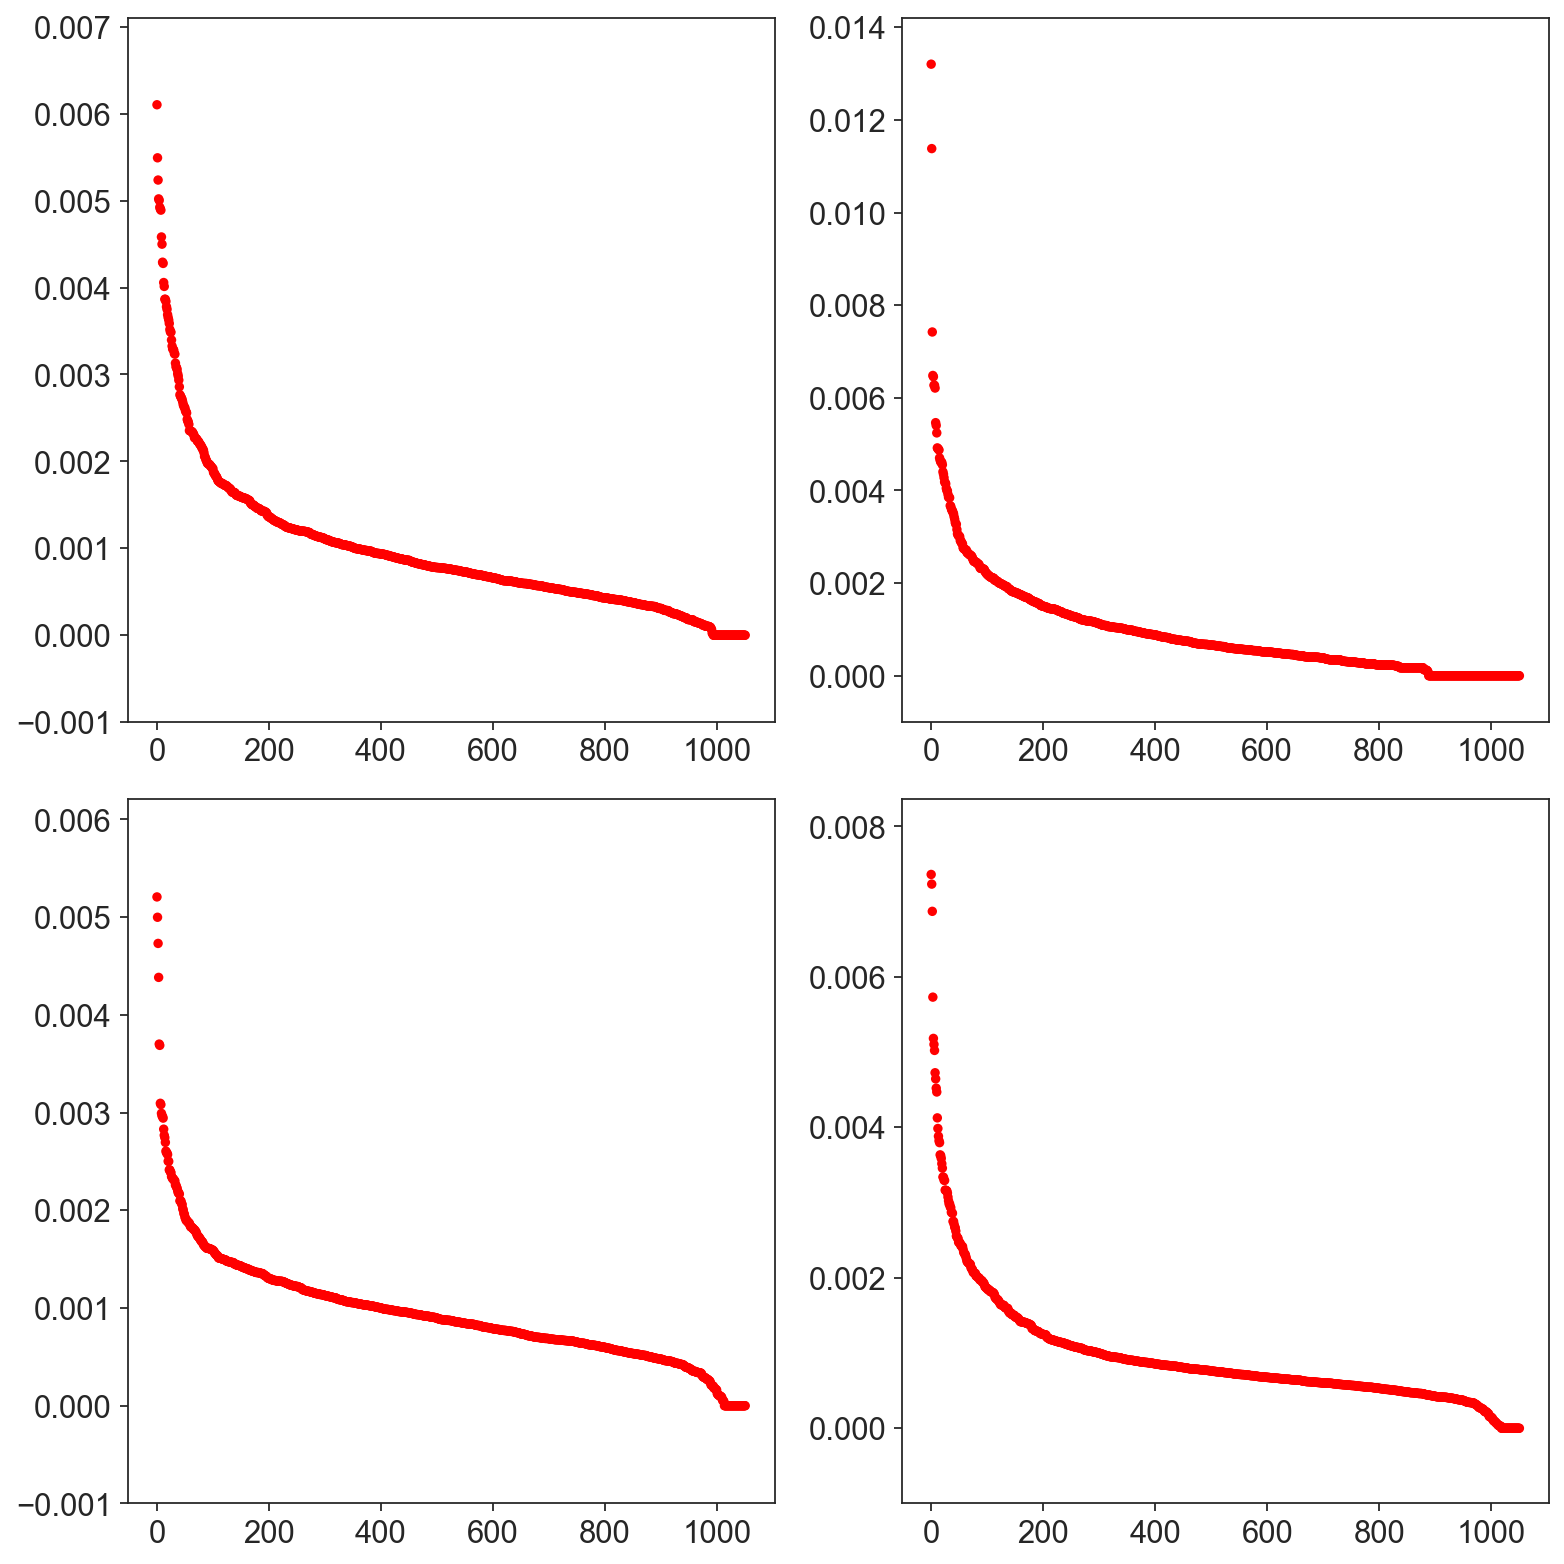

In [115]:
sns.set_style('white')
sns.set_style('ticks')
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False, sharey=False)
X = pt_obs_metabolites_pre_relevant

k = 0
for i in range(2):
    for j in range(2):
        if k==3:
            X = X.drop(columns='who_ordinal_scale')
        importances = test_results[k].pre_clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in test_results[k].pre_clf.estimators_], axis=0)
        indices = np.argsort(test_results[k].pre_clf.feature_importances_)[::-1]
        f = sns.scatterplot(x=range(X.shape[1]), y=importances[indices], 
                        linewidth=0, color='r', size=0.1, legend=None, 
                        ax=axes[i, j]) 
        f.set(ylim=[-0.001, max(importances) + 0.001])
        #, yerr=std[indices], align='center')
        #plt.xticks(range(X.shape[1]), indices)
        #plt.xticks([])
        #plt.xlim([-1, X.shape[1]])
        #plt.ylim([0, max(importances)])
        
        k += 1

plt.tight_layout()

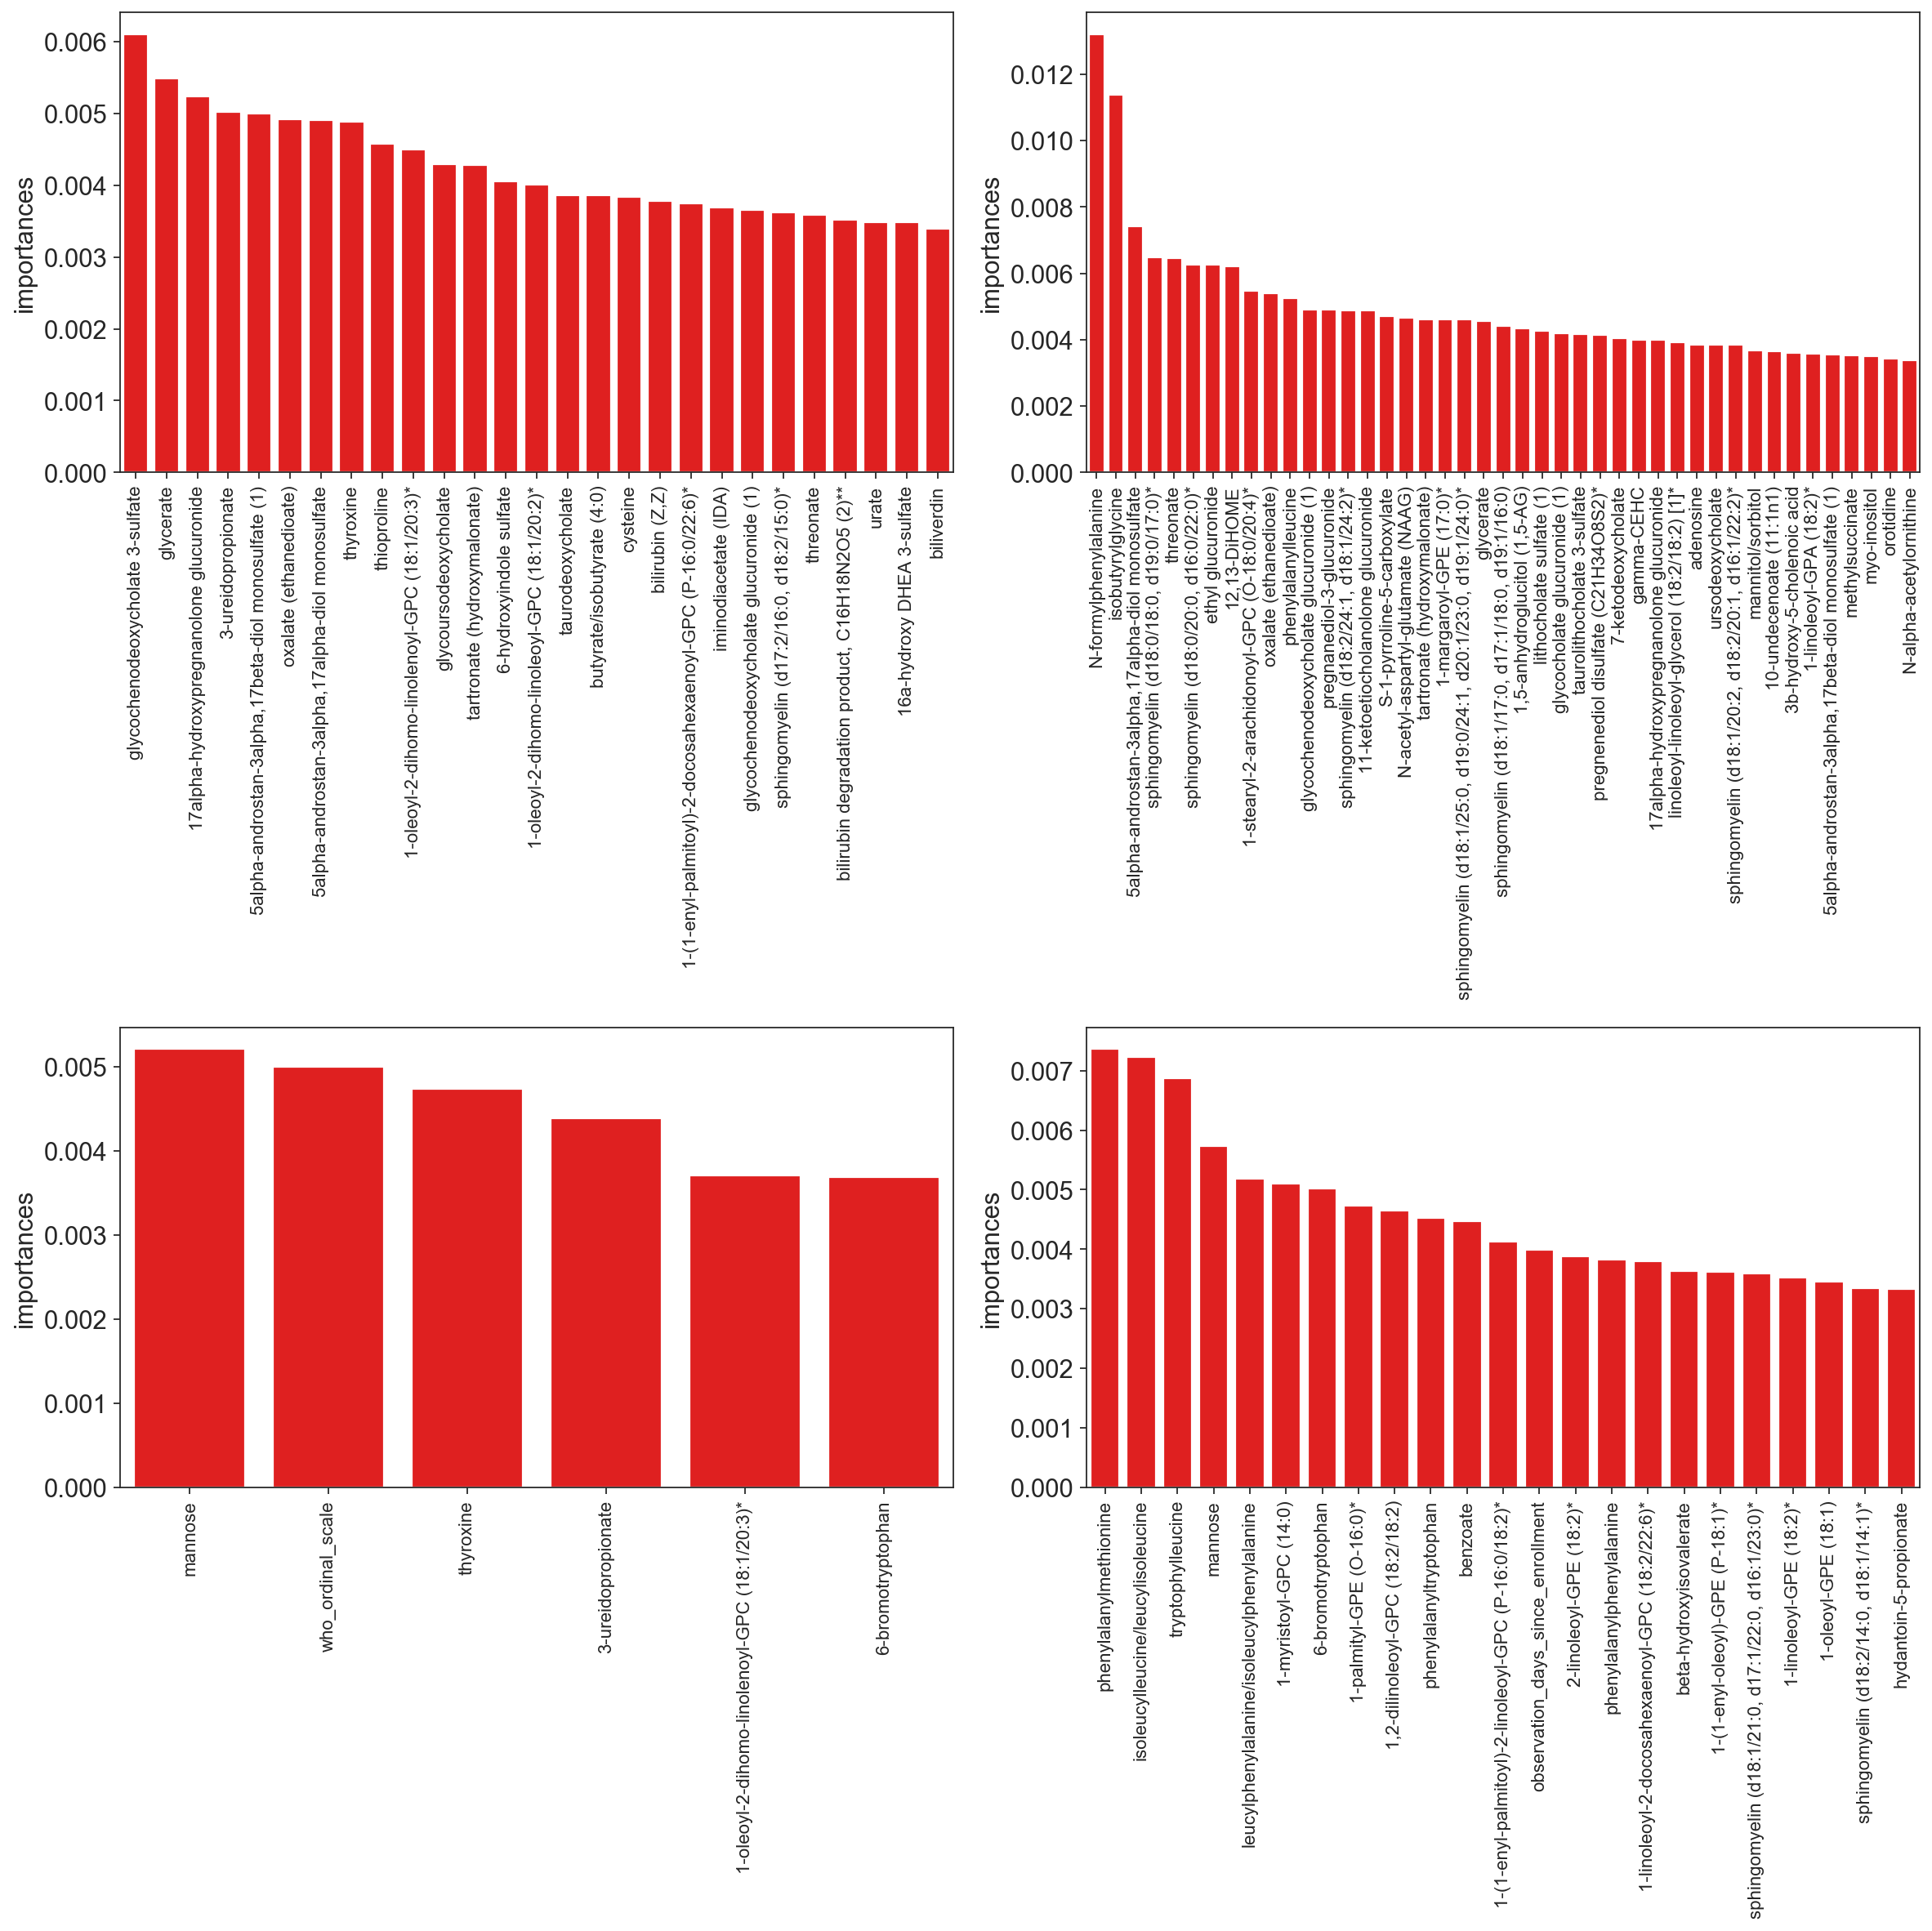

In [116]:
# Top feature importances from the feature selection trees before the actual classifier
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=False, sharey=False)
X = pt_obs_metabolites_pre_relevant

k = 0
for i in range(2):
    for j in range(2):
        if k==3:
            X = pt_obs_metabolites_pre_relevant.drop(columns=['who_ordinal_scale'])
        importances = test_results[k].pre_clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in test_results[k].pre_clf.estimators_], axis=0)
        indices = np.where(X.columns.isin(test_results[k].selected_features))[0]
        temp = pd.DataFrame(columns=['importances'])
        temp['importances'] = importances[indices]
        temp.index = indices
        temp = temp.sort_values(by='importances', ascending=False)

        sns.set_style('white')
        sns.set_style('ticks')
        f = sns.barplot(x=np.arange(len(temp.index)), y=temp['importances'], ax=axes[i, j], color='red')
        plt.sca(axes[i, j])
        plt.xticks(np.arange(len(temp.index)), X.columns[temp.index], rotation=90, fontsize=10)
        
        k += 1

plt.tight_layout()

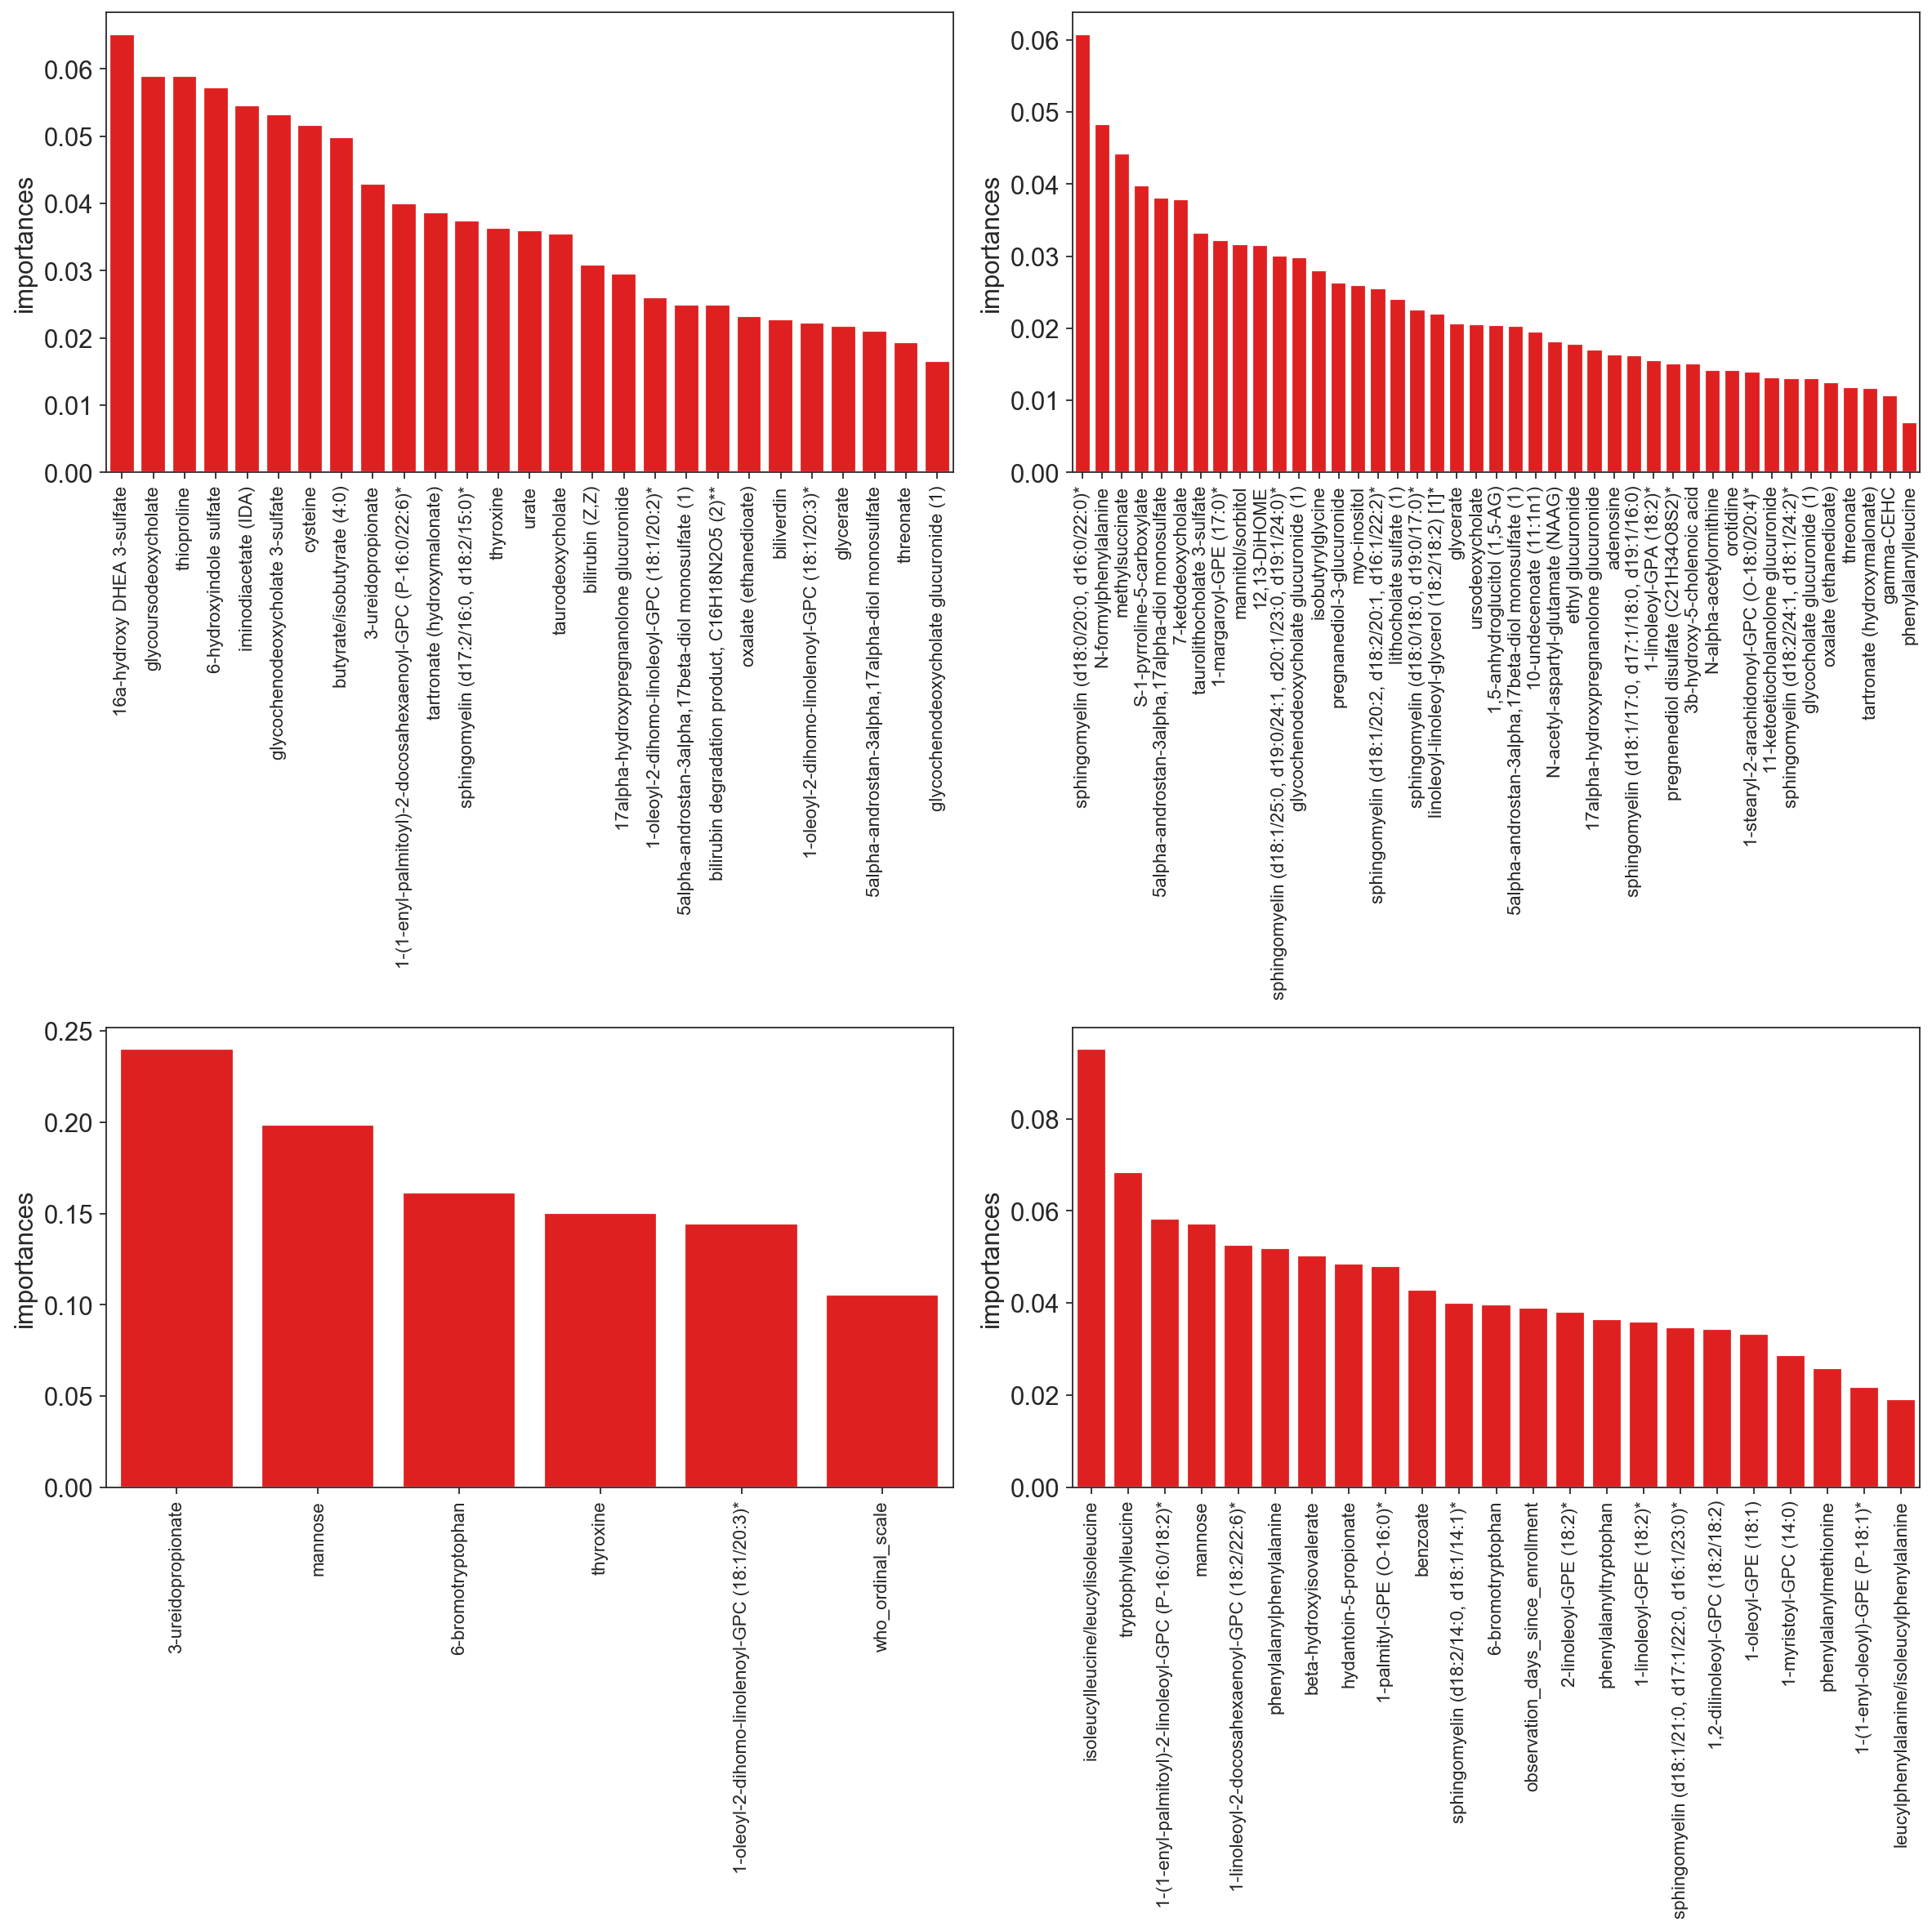

In [117]:
# Top feature importances from the actuall random forest classifier
# There is some reordering vs. the pre_clf, probably because we have a narrower set of features and not many samples
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=False, sharey=False)
X = pt_obs_metabolites_pre_relevant

k = 0
for i in range(2):
    for j in range(2):
        if k==3:
            X = pt_obs_metabolites_pre_relevant.drop(columns=['who_ordinal_scale'])
        importances = test_results[k].clf[1].feature_importances_
        std = np.std([tree.feature_importances_ for tree in test_results[k].clf[1].estimators_], axis=0)
        temp = pd.DataFrame(columns=['importances'])
        temp['importances'] = importances
        temp.index = test_results[k].selected_features
        temp = temp.sort_values(by='importances', ascending=False)

        sns.set_style('white')
        sns.set_style('ticks')
        f = sns.barplot(x=np.arange(len(test_results[k].selected_features)), 
                        y=temp['importances'], ax=axes[i, j], color='red')
        plt.sca(axes[i, j])
        plt.xticks(np.arange(len(test_results[k].selected_features)), 
                   temp.index, rotation=90, fontsize=10)
        
        k += 1

plt.tight_layout()

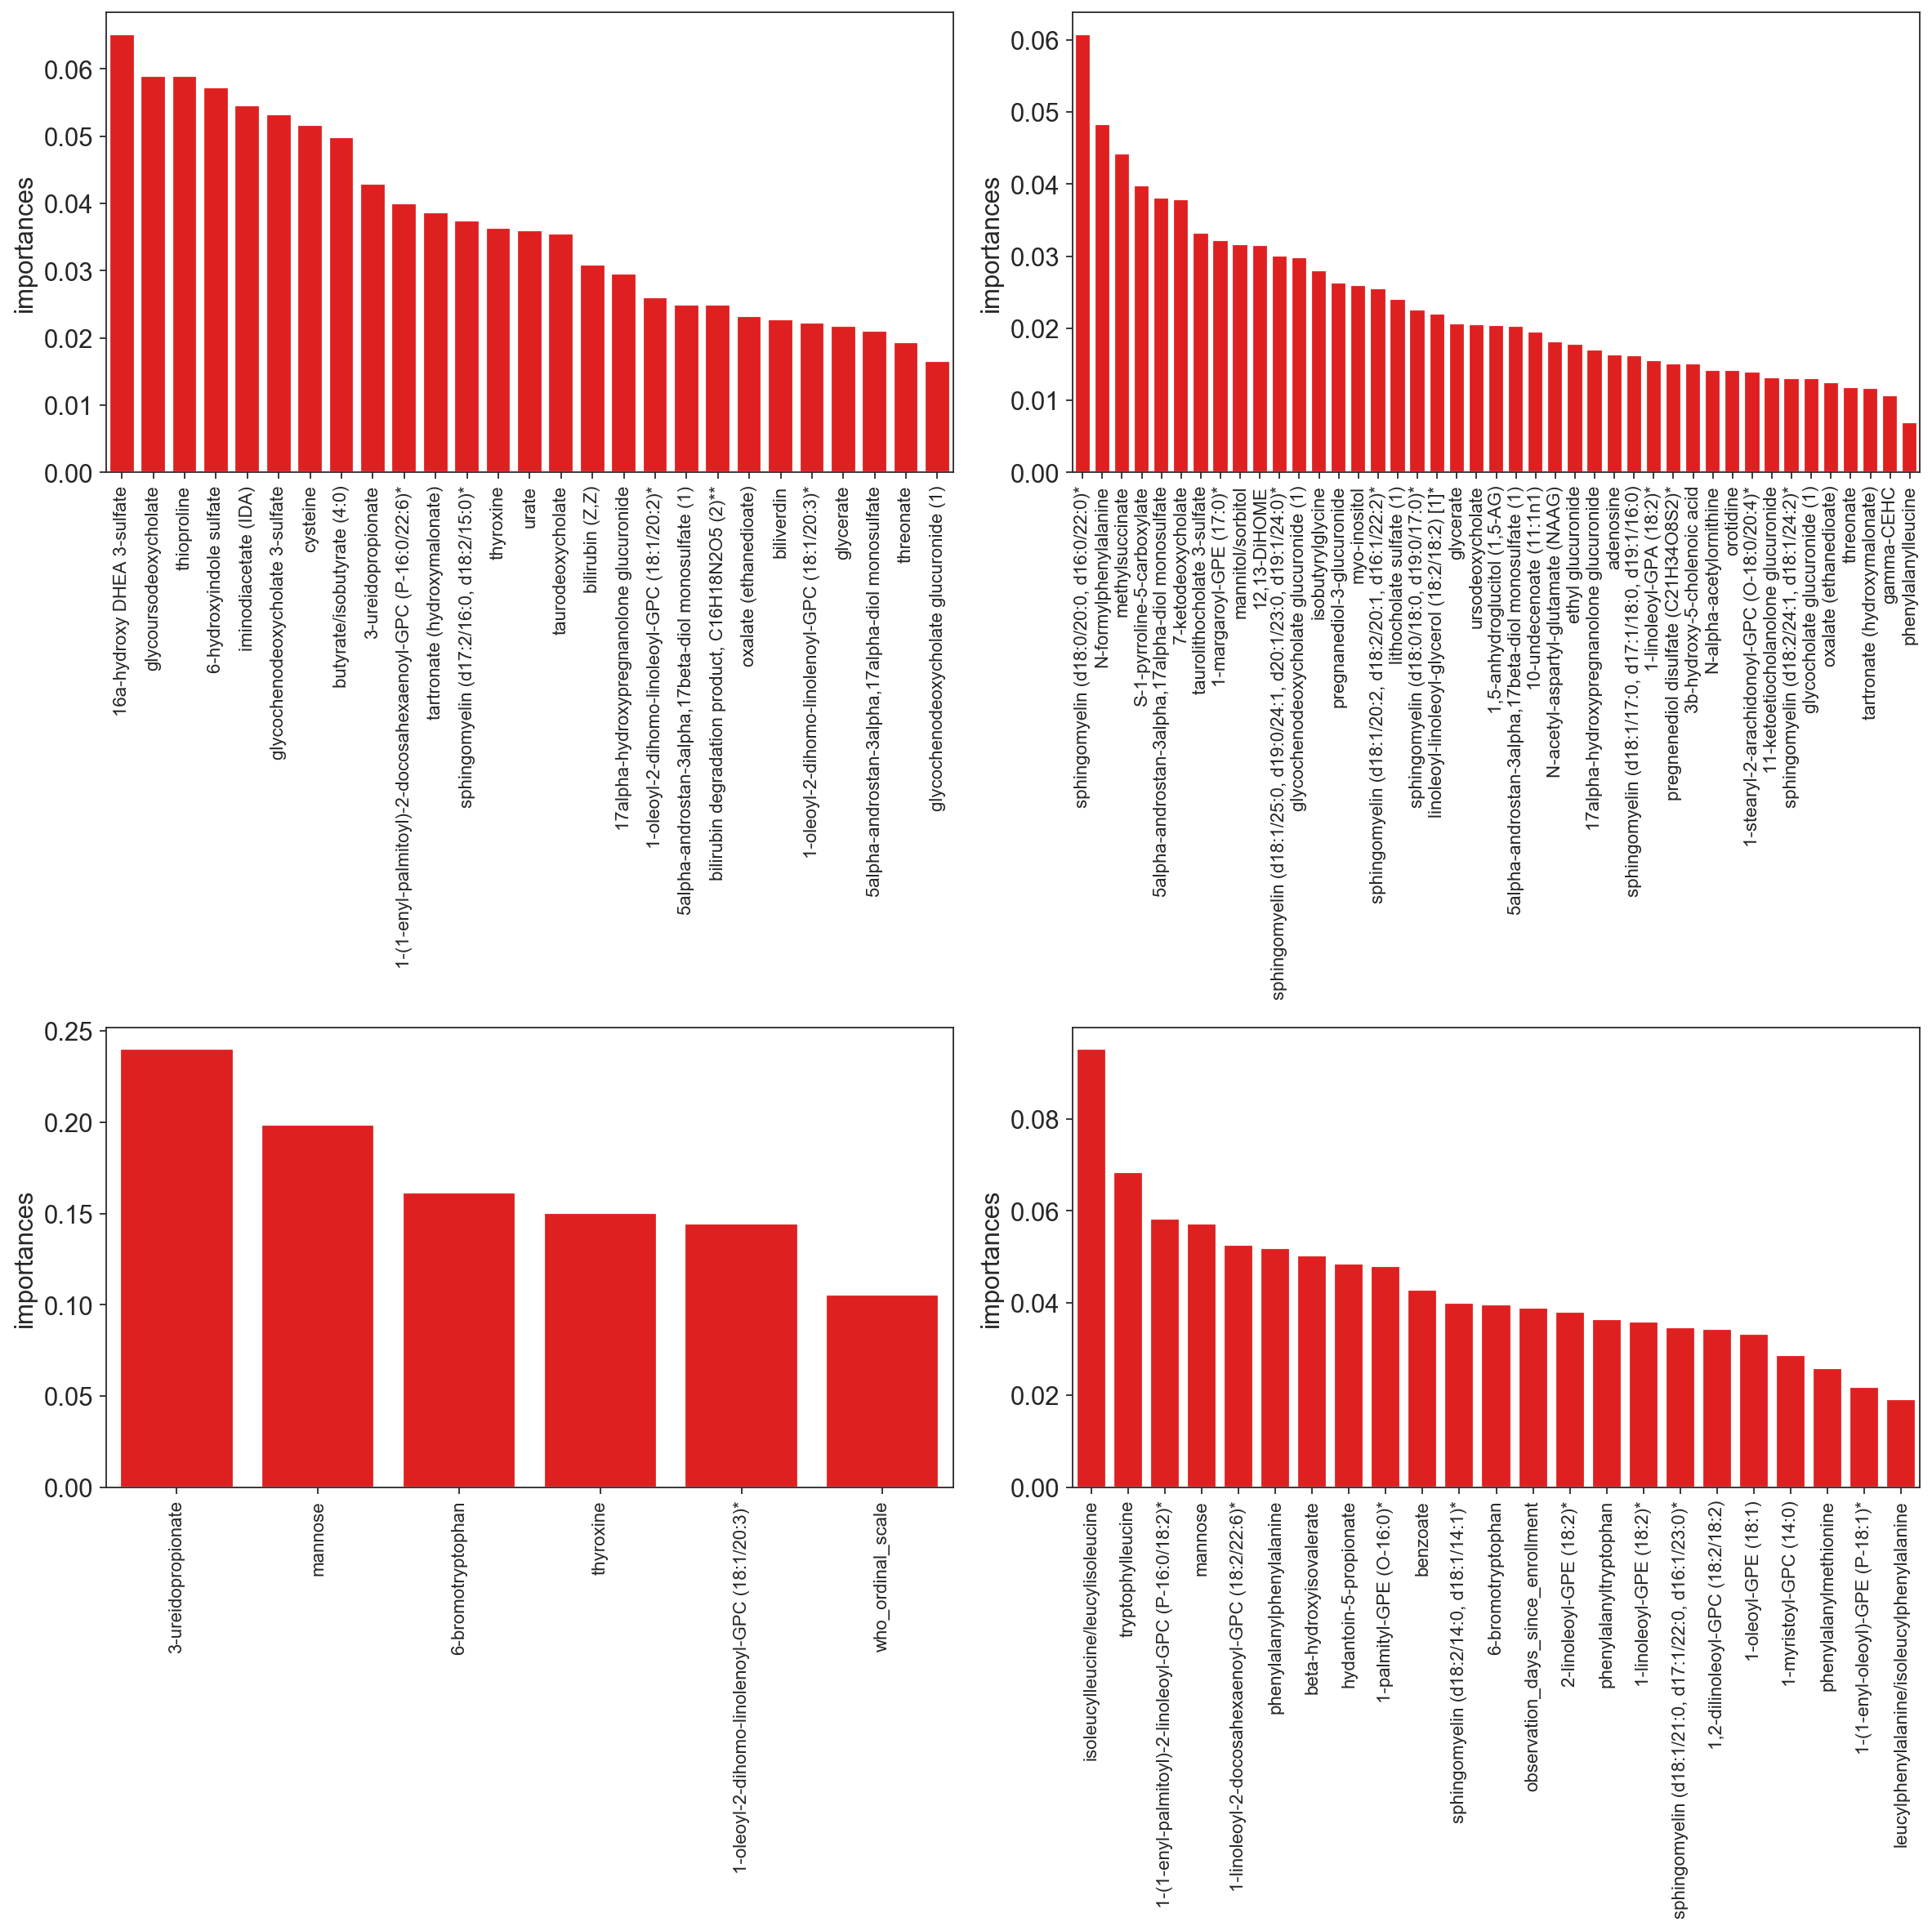

In [24]:
# Top feature importances from the actuall random forest classifier
# There is some reordering vs. the pre_clf, probably because we have a narrower set of features and not many samples
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=False, sharey=False)
X = pt_obs_metabolites_pre_relevant

k = 0
for i in range(2):
    for j in range(2):
        if k==3:
            X = pt_obs_metabolites_pre_relevant.drop(columns=['who_ordinal_scale'])
        importances = test_results[k].clf[1].feature_importances_
        std = np.std([tree.feature_importances_ for tree in test_results[k].clf[1].estimators_], axis=0)
        temp = pd.DataFrame(columns=['importances'])
        temp['importances'] = importances
        temp.index = test_results[k].selected_features
        temp = temp.sort_values(by='importances', ascending=False)

        sns.set_style('white')
        sns.set_style('ticks')
        f = sns.barplot(x=np.arange(len(test_results[k].selected_features)), 
                        y=temp['importances'], ax=axes[i, j], color='red')
        plt.sca(axes[i, j])
        plt.xticks(np.arange(len(test_results[k].selected_features)), 
                   temp.index, rotation=90, fontsize=10)
        
        k += 1

plt.tight_layout()

In [25]:
len(test_results[0].selected_features)

27

In [26]:
# Feature importances are quite variable due to the lack of data points 
# Std error thus may not be so informative here
[tree.feature_importances_[indices] for tree in test_results[3].pre_clf.estimators_]

[array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.01739208, 0.        , 0.        , 0.        , 0.17695299,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.01014981]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.06616555, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01605261,
        0.        , 0.09326946, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]),
 array([0.02090898, 0.        , 0.0515427 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.04799514,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]),
 array([0.        , 0.        , 0.        , 0.

In [27]:
predictions = pd.DataFrame(np.zeros([len(pt_obs_metabolites_pre_relevant), 4]) - 1)
predictions.index = pt_obs_metabolites_pre_relevant.index
predictions.columns = ['RDV', 'Tocilizumab', 'general', 'general_noDiff']#, 'Vitamin C', 'Zinc']
for i in range(4):
    predictions.iloc[:, i] = tx_clfs[i].predict(pt_obs_metabolites_pre_relevant.loc[:, 
                                                                              test_results[i].selected_features])
    predictions = predictions.astype(int)
    print('Mean absolute error (test) = ' + str(np.mean(abs(test_results[i].y_test - \
                      predictions.loc[test_results[i].y_test.index, predictions.columns[i]]))))
    print('Max absolute error (test) = ' + str(np.sum(max(test_results[i].y_test - \
                      predictions.loc[test_results[i].y_test.index, predictions.columns[i]]))))
    print('All errors (test) = ' + str(test_results[i].y_test - \
                      predictions.loc[test_results[i].y_test.index, predictions.columns[i]]))

predictions.loc[test_results[0].y_train.index.union(test_results[0].y_test.index), 'actual-RDV_predicted'] = \
    pt_obs_metabolites_pre.loc[test_results[0].y_train.index.union(test_results[0].y_test.index), 'tx_result_wrt_general'] - \
    predictions.loc[test_results[0].y_train.index.union(test_results[0].y_test.index), 'RDV']

predictions.loc[test_results[1].y_train.index.union(test_results[1].y_test.index), 'actual-Tocilizumab_predicted'] = \
    pt_obs_metabolites_pre.loc[test_results[1].y_train.index.union(test_results[1].y_test.index), 'tx_result_wrt_general'] - \
    predictions.loc[test_results[1].y_train.index.union(test_results[1].y_test.index), 'Tocilizumab']

predictions.loc[test_results[2].y_train.index.union(test_results[2].y_test.index), 'actual-general_predicted'] = \
    pt_obs_metabolites_pre.loc[test_results[2].y_train.index.union(test_results[2].y_test.index), 'tx_result_wrt_general'] - \
    predictions.loc[test_results[2].y_train.index.union(test_results[2].y_test.index), 'general']

predictions.loc[test_results[3].y_train.index.union(test_results[3].y_test.index), 'actual-general_noDiff_predicted'] = \
    pt_obs_metabolites_pre.loc[test_results[3].y_train.index.union(test_results[3].y_test.index), 'tx_result_wrt_general_noDiff'] - \
    predictions.loc[test_results[3].y_train.index.union(test_results[3].y_test.index), 'general_noDiff']

for i in range(len(['RDV', 'Tocilizumab', 'general', 'general_noDiff'])):
    predictions.loc[test_results[i].y_train.index, predictions.columns[i] + '_sample_type'] = 'train'
    predictions.loc[test_results[i].y_test.index, predictions.columns[i] + '_sample_type'] = 'test'

predictions.iloc[:50]
#predictions.loc[test_results[-1].y_test.index]

Mean absolute error (test) = 0.4166666666666667
Max absolute error (test) = 1.0
All errors (test) = source_label
INCOV075   -1.0
INCOV111    0.0
INCOV053    0.0
INCOV005    1.0
INCOV014    1.0
INCOV051    0.0
INCOV059   -1.0
INCOV015    1.0
INCOV117    0.0
INCOV079    0.0
INCOV062    0.0
INCOV034    0.0
dtype: float64
Mean absolute error (test) = 0.4
Max absolute error (test) = 0.0
All errors (test) = source_label
INCOV003   -2.0
INCOV014    0.0
INCOV016    0.0
INCOV018    0.0
INCOV035    0.0
dtype: float64
Mean absolute error (test) = 0.6451612903225806
Max absolute error (test) = 1.0
All errors (test) = source_label
INCOV098   -2.0
INCOV113    0.0
INCOV011    0.0
INCOV080    0.0
INCOV009    0.0
INCOV050    0.0
INCOV024   -1.0
INCOV008    1.0
INCOV070   -4.0
INCOV105   -3.0
INCOV131    0.0
INCOV126    0.0
INCOV035    0.0
INCOV075    0.0
INCOV003    1.0
INCOV104   -2.0
INCOV103    0.0
INCOV026    0.0
INCOV142    0.0
INCOV032    0.0
INCOV090    1.0
INCOV115    0.0
INCOV069   -2.0
INCOV0

RDV  Tocilizumab  general  general_noDiff  actual-RDV_predicted  \
source_label                                                                    
INCOV001        0            1        0               3                   0.0   
INCOV002        2            2        2               5                   0.0   
INCOV003       -1            1       -2               7                   0.0   
INCOV004        0            0        0               4                   0.0   
INCOV005        0            1        1               4                   1.0   
INCOV006       -1           -1       -1               4                   0.0   
INCOV007        0            0        0               4                   0.0   
INCOV008       -1            0       -1               4                   NaN   
INCOV009        0            0        0               4                   0.0   
INCOV010        0            0       -2               3                   NaN   
INCOV011        0            0        0               4                   NaN   
INCOV012        0            0        0               4                   0.0   
INCOV013       -2           -2       -2               7                   0.0   
INCOV014        0            1        0               3                   1.0   
INCOV015        0            1        1               4                   1.0   
INCOV016        0            0        0               4                   0.0   
INCOV017        0            1        0               4                   0.0   
INCOV018        0            0        0               3                   0.0   
INCOV019        0            0        0               3                   NaN   
INCOV020        0            0       -1               7                   NaN   
INCOV021        0            0        0               4                   NaN   
INCOV022       -1            0       -1               7                   NaN   
INCOV023        0            0        0               3                   0.0   
INCOV024        0            0        0               1                   NaN   
INCOV025       -1            0        0               5                   NaN   
INCOV026        0            0        0               4                   0.0   
INCOV027        1            1        1               3                   0.0   
INCOV028        0            0       -1               4                   NaN   
INCOV029        0            0       -1               5                   NaN   
INCOV030       -1            0       -1               4                   0.0   
INCOV031        0            0        0               6                   NaN   
INCOV032        0            0        0               4                   NaN   
INCOV033        0            1        0               5                   0.0   
INCOV034       -2            1       -2               3                   0.0   
INCOV035        0            0        0               7                   NaN   
INCOV036       -1           -1       -1               7                   NaN   
INCOV037        0            0        0               4                   0.0   
INCOV038        0            0        0               4                   NaN   
INCOV039        0            1        0               1                   NaN   
INCOV040        0            0       -2               3                   NaN   
INCOV041        0            1        1               5                   NaN   
INCOV042        0            0        0               1                   NaN   
INCOV043        0            0        0               3                   NaN   
INCOV044        0            0        0               4                   0.0   
INCOV045        0            1       -3               4                   NaN   
INCOV047        0            0        0               5                   0.0   
INCOV048        0            0        0               7                   NaN   
INCOV049        0            1        0      

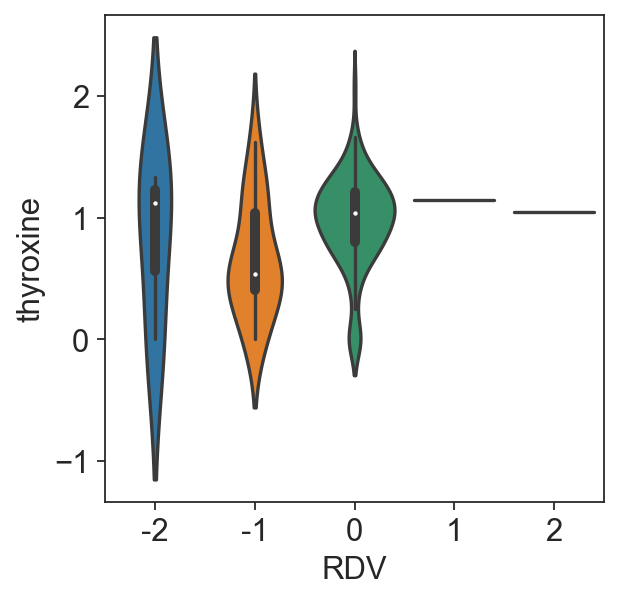

In [28]:
sns.violinplot(x='RDV', 
        y='thyroxine', data=pd.merge(predictions, pt_obs_metabolites_pre_relevant, left_index=True, right_index=True))

In [29]:
# Spearman correlation: positive thyroxine vs. RDV means that more thyroxine means greater positive difference (worse)
df_predictors = pd.DataFrame(columns=['tx', 'feature', 'Spearman_r', 'pvalue'])

for i, tx in enumerate(predictions.columns[:4]):
    features = test_results[i].selected_features
    for feature in features:
        temp = spearmanr(pd.merge(predictions, pt_obs_metabolites_pre_relevant, 
                                  left_index=True, right_index=True)[feature], 
             pd.merge(predictions, pt_obs_metabolites_pre_relevant, left_index=True, right_index=True)[tx])
        df_predictors = df_predictors.append({'tx': tx, 'feature': feature, 'Spearman_r': temp[0], 'pvalue': temp[1]}, 
                                             ignore_index=True)

In [30]:
#df_predictors.to_csv(master_dir + 'output/sklearn/predictors.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


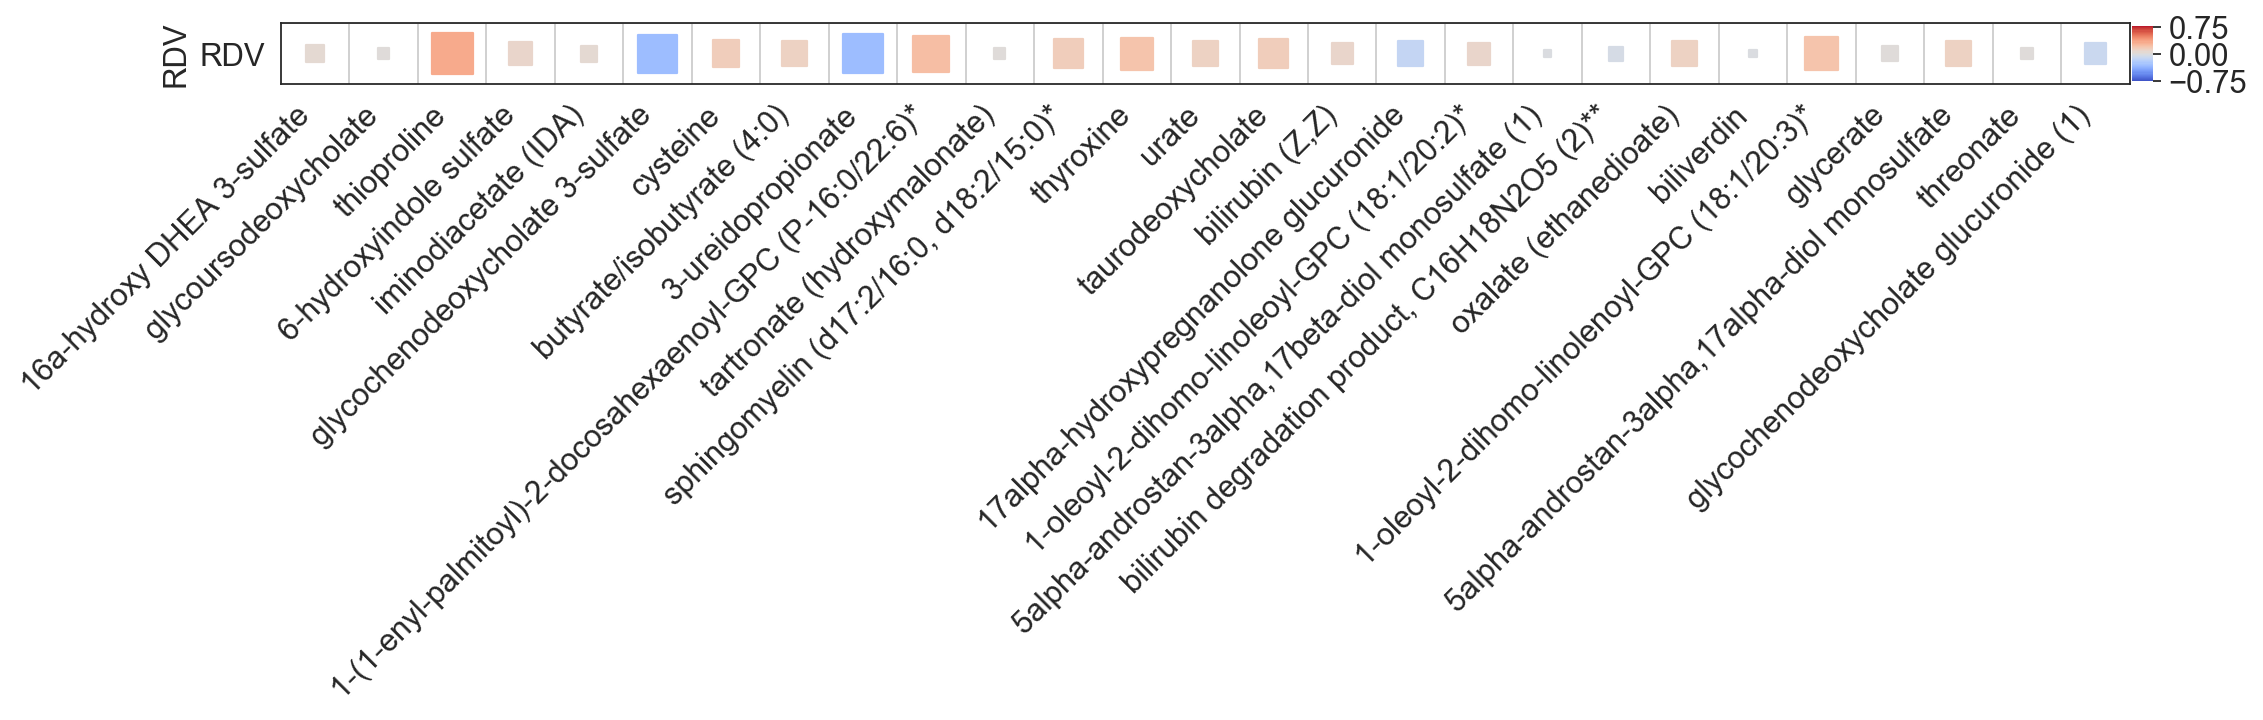

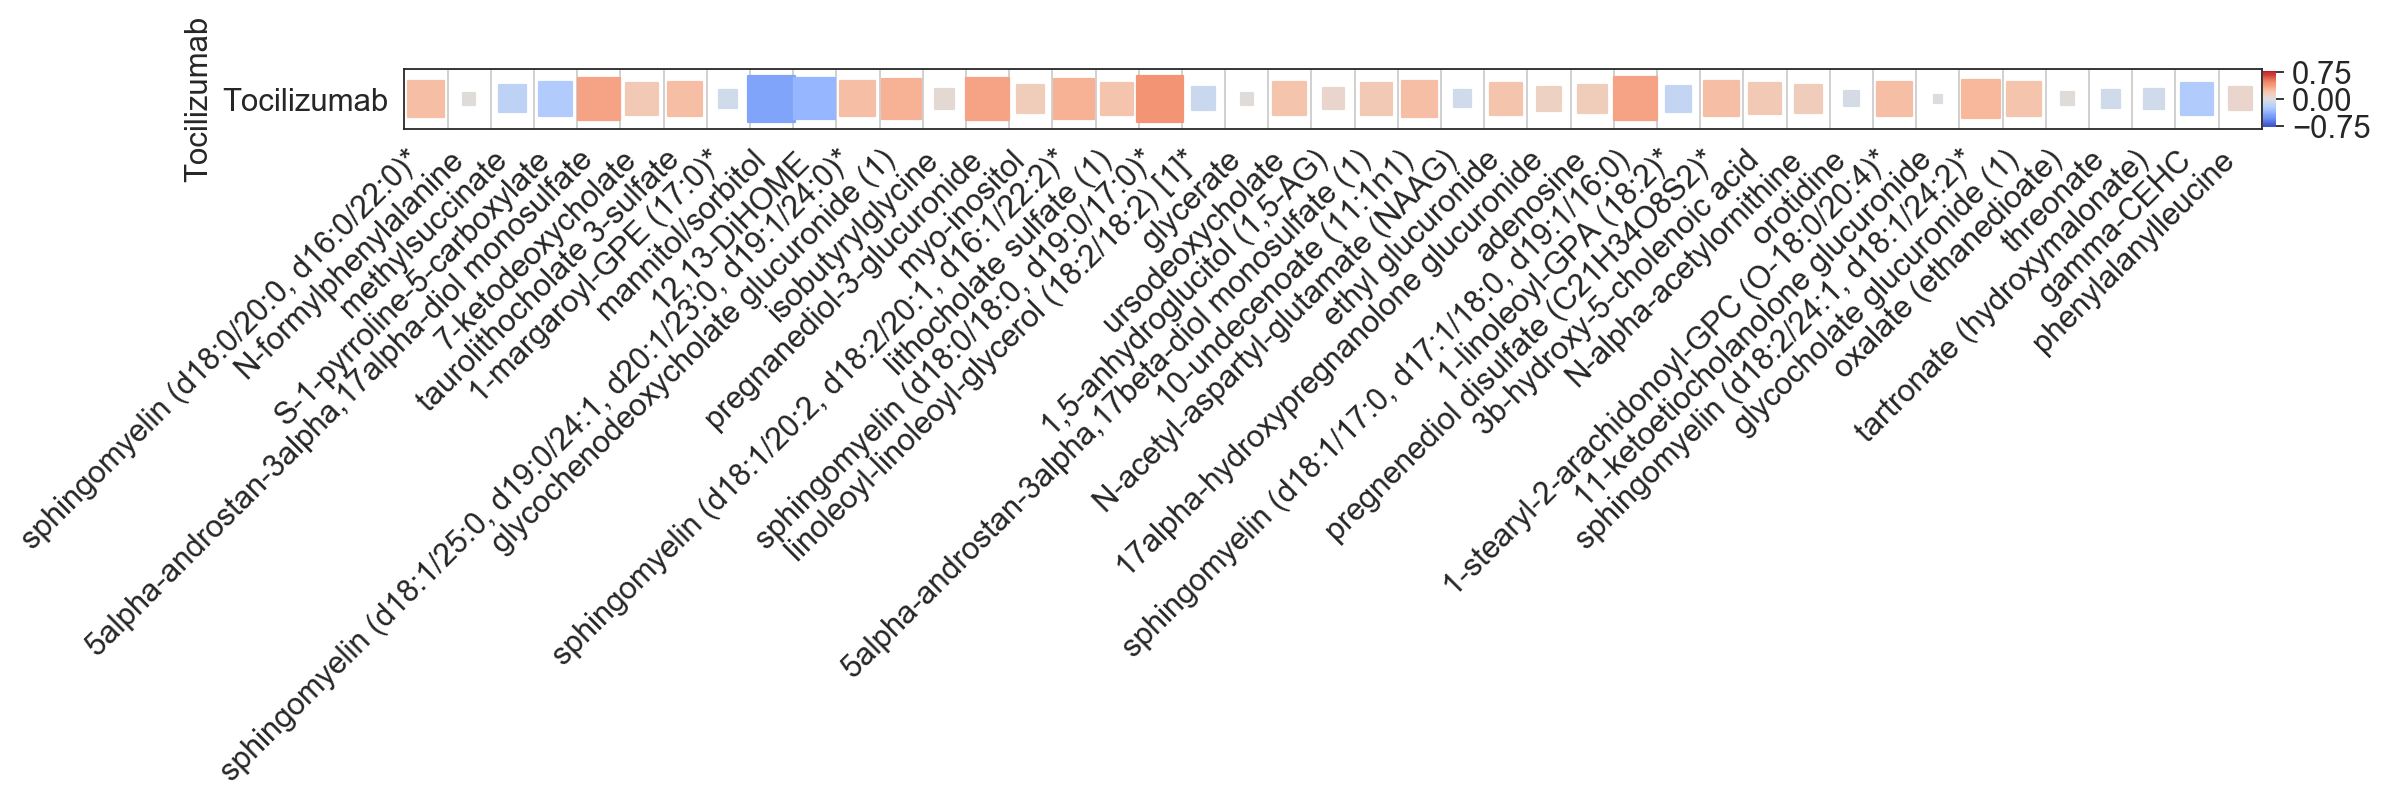

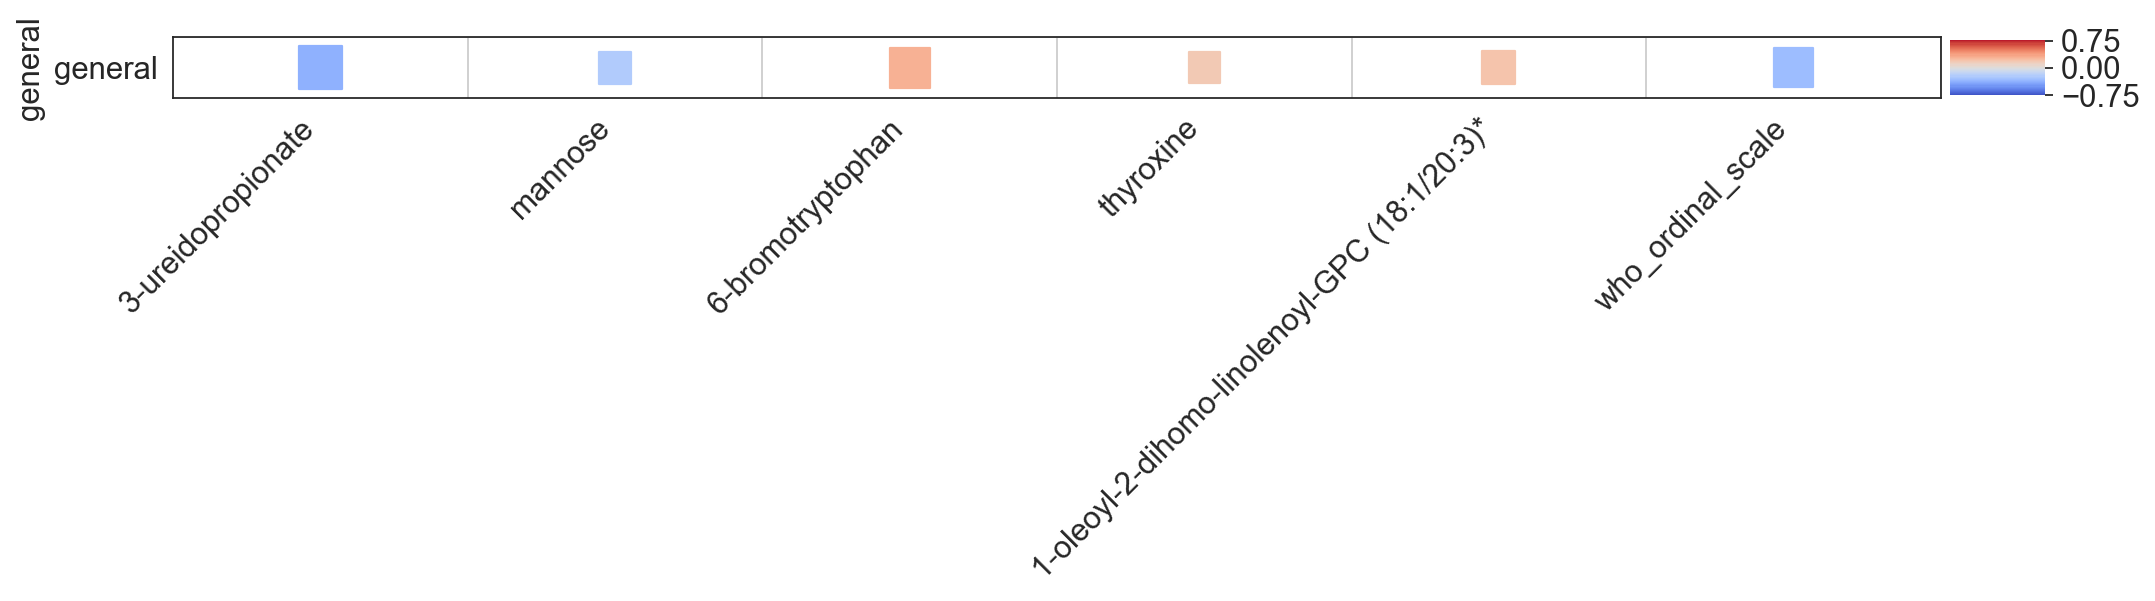

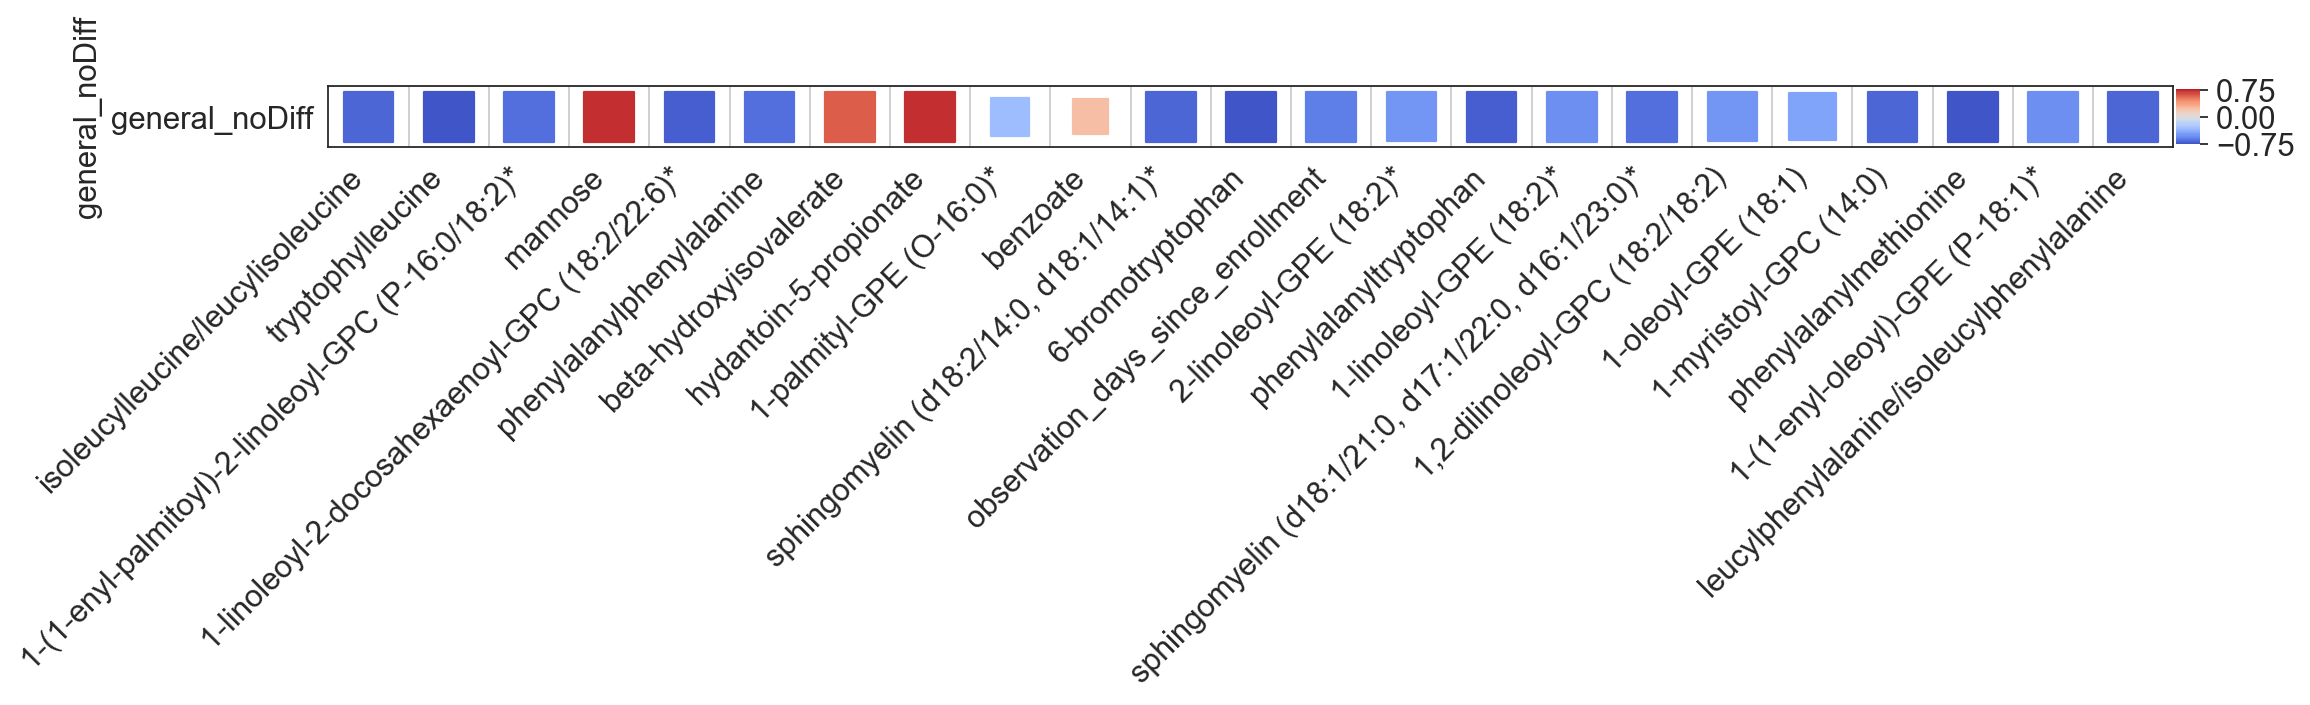

In [74]:
#f, axes = plt.subplots(4, 1, figsize=(10, 5), sharex=False, sharey=False)
sns.set_style('white')
for i, tx in enumerate(predictions.columns[:4]):
    f = plt.figure(figsize=(15, 0.5))
    temp = df_predictors[df_predictors['tx']==tx]
    temp['importance'] = test_results[i].clf[1].feature_importances_
    temp = temp.sort_values(by='importance', ascending=False)
    temp.index = temp['feature']
    heatmap(x=temp.index, 
            y=temp['tx'], ylabel=tx, 
            color=temp['Spearman_r'], palette=sns.color_palette('coolwarm', n_colors=50),
            size=abs(temp['Spearman_r']),
            norm=DivergingNorm(0),
            color_range=[-0.75, 0.75],
            size_range=[0, 0.5],
            x_order=[x for x in temp.index])
    f.show()
    plt.savefig(master_dir + 'output/sklearn/predictors_correlations-' + tx + '.svg')
    
#heatmap(
#    x=pc1g.index,#['short_index'],
#    ylabel='PC1',
#    y=pc1g['PC'],
#    color=pc1g['Spearman'],
#    size=abs(pc1g['loading_score']),
#    palette=sns.color_palette('coolwarm'),
#    norm=DivergingNorm(0),
#    x_order=[x for x in pathway_metabolites_list.index if x in pc1g.index]
#)

In [122]:
df_predictors[df_predictors['tx']=='RDV']

tx                                            feature  Spearman_r  \
0   RDV                                         biliverdin   -0.006425   
1   RDV                                           cysteine    0.140054   
2   RDV                                          glycerate    0.042626   
3   RDV                                 3-ureidopropionate   -0.311098   
4   RDV                                    bilirubin (Z,Z)    0.081724   
5   RDV                                          thyroxine    0.202068   
6   RDV                                              urate    0.121109   
7   RDV                         butyrate/isobutyrate (4:0)    0.126328   
8   RDV                                  taurodeoxycholate    0.164745   
9   RDV                       tartronate (hydroxymalonate)    0.019777   
10  RDV                             oxalate (ethanedioate)    0.124721   
11  RDV                               iminodiacetate (IDA)    0.047122   
12  RDV                                          threonate    0.021339   
13  RDV   5alpha-androstan-3alpha,17alpha-diol monosulfate    0.120591   
14  RDV  5alpha-androstan-3alpha,17beta-diol monosulfat...    0.003558   
15  RDV                         16a-hydroxy DHEA 3-sulfate    0.058812   
16  RDV                              glycoursodeoxycholate    0.019763   
17  RDV            17alpha-hydroxypregnanolone glucuronide   -0.125464   
18  RDV                            6-hydroxyindole sulfate    0.099195   
19  RDV                   glycochenodeoxycholate 3-sulfate   -0.291248   
20  RDV  1-(1-enyl-palmitoyl)-2-docosahexaenoyl-GPC (P-...    0.256791   
21  RDV      1-oleoyl-2-dihomo-linolenoyl-GPC (18:1/20:3)*    0.208326   
22  RDV                                        thioproline    0.338890   
23  RDV             glycochenodeoxycholate glucuronide (1)   -0.089446   
24  RDV       1-oleoyl-2-dihomo-linoleoyl-GPC (18:1/20:2)*    0.092475   
25  RDV            sphingomyelin (d17:2/16:0, d18:2/15:0)*    0.165538   
26  RDV    bilirubin degradation product, C16H18N2O5 (2)**   -0.034011   

      pvalue  
0   0.941712  
1   0.109222  
2   0.627467  
3   0.000283  
4   0.351560  
5   0.020151  
6   0.166572  
7   0.148913  
8   0.059067  
9   0.821916  
10  0.154193  
11  0.591583  
12  0.808114  
13  0.168408  
14  0.967703  
15  0.502954  
16  0.822038  
17  0.151734  
18  0.257794  
19  0.000704  
20  0.002956  
21  0.016527  
22  0.000070  
23  0.307762  
24  0.291600  
25  0.057840  
26  0.698643

In [40]:
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=False, sharey=False)

df_predictors[df_predictors['tx']=='RDV']
importances = test_results[k].clf[1].feature_importances_

tx                                            feature  Spearman_r  \
0   RDV                                         biliverdin   -0.006425   
1   RDV                                           cysteine    0.140054   
2   RDV                                          glycerate    0.042626   
3   RDV                                 3-ureidopropionate   -0.311098   
4   RDV                                    bilirubin (Z,Z)    0.081724   
5   RDV                                          thyroxine    0.202068   
6   RDV                                              urate    0.121109   
7   RDV                         butyrate/isobutyrate (4:0)    0.126328   
8   RDV                                  taurodeoxycholate    0.164745   
9   RDV                       tartronate (hydroxymalonate)    0.019777   
10  RDV                             oxalate (ethanedioate)    0.124721   
11  RDV                               iminodiacetate (IDA)    0.047122   
12  RDV                                          threonate    0.021339   
13  RDV   5alpha-androstan-3alpha,17alpha-diol monosulfate    0.120591   
14  RDV  5alpha-androstan-3alpha,17beta-diol monosulfat...    0.003558   
15  RDV                         16a-hydroxy DHEA 3-sulfate    0.058812   
16  RDV                              glycoursodeoxycholate    0.019763   
17  RDV            17alpha-hydroxypregnanolone glucuronide   -0.125464   
18  RDV                            6-hydroxyindole sulfate    0.099195   
19  RDV                   glycochenodeoxycholate 3-sulfate   -0.291248   
20  RDV  1-(1-enyl-palmitoyl)-2-docosahexaenoyl-GPC (P-...    0.256791   
21  RDV      1-oleoyl-2-dihomo-linolenoyl-GPC (18:1/20:3)*    0.208326   
22  RDV                                        thioproline    0.338890   
23  RDV             glycochenodeoxycholate glucuronide (1)   -0.089446   
24  RDV       1-oleoyl-2-dihomo-linoleoyl-GPC (18:1/20:2)*    0.092475   
25  RDV            sphingomyelin (d17:2/16:0, d18:2/15:0)*    0.165538   
26  RDV    bilirubin degradation product, C16H18N2O5 (2)**   -0.034011   

      pvalue  
0   0.941712  
1   0.109222  
2   0.627467  
3   0.000283  
4   0.351560  
5   0.020151  
6   0.166572  
7   0.148913  
8   0.059067  
9   0.821916  
10  0.154193  
11  0.591583  
12  0.808114  
13  0.168408  
14  0.967703  
15  0.502954  
16  0.822038  
17  0.151734  
18  0.257794  
19  0.000704  
20  0.002956  
21  0.016527  
22  0.000070  
23  0.307762  
24  0.291600  
25  0.057840  
26  0.698643

In [31]:
spearmanr(pd.merge(predictions, pt_obs_metabolites_pre_relevant, left_index=True, right_index=True)['thyroxine'], 
         pd.merge(predictions, pt_obs_metabolites_pre_relevant, left_index=True, right_index=True)['general'])

SpearmanrResult(correlation=0.19114178804371898, pvalue=0.028131443251759425)

In [32]:
#predictions.to_csv(master_dir + 'output/sklearn/predictions.csv')

## Metabolic pathway activity changes as a result of different treatments

- How does each drug affect metabolic pathways in patients who improve, worsen, or are stable with the treatment? How do these changes compare with those who are not treated with the drug from one timepoint to the other?
- Show the kinetic difference in pathway activity

In [37]:
# Required functions

# Here, cell type is defined as individual clusters ('louvain')
# within a given group of immune cells (B cells, T cells, etc.)
# Clusters calculated from all genes rather than just metabolic genes
# in order to associate the metabolic gene set enrichment with the non-metabolic analyses
def pathway_activity(data, data_metab, cluster_label, print_labels=False, nanval=0, exclude_clusters=[]):
    cluster_ids = list(data.obs[cluster_label].unique())
    cluster_ids.sort()
    
    for cluster_id in exclude_clusters:
        cluster_ids.remove(cluster_id)
        
    mel = np.zeros([len(cluster_ids), len(data_metab.X[0])])
    for i, cluster_id in enumerate(cluster_ids):
        if print_labels:
            print(cluster_id)
        cluster = data_metab[data.obs[cluster_label]==cluster_id]
        g = cluster.X # Matrix of gene expression of ith gene in the kth cell of this cluster (cell type)
        n = len(cluster) # Number of cells in the cluster (cell type)
        # Calculate mean expression level
        mel[i] = np.sum(g, axis=0) / n # Sum gene expressions per gene across all cells in this cluster (cell type),
            # divided by number of cells in the cluster (cell type)        

    # Remove genes that are 0 in any cluster to avoid extreme ratio value
    mel = np.array(mel)
    m = min(mel[mel > 0])
    mel[mel==0] = m
            
    # Calculate relative expression level of each gene
    rel = mel / (np.sum(mel, axis=0) / len(mel))

    # Filtering
    lowExpr, highExpr = np.percentile(rel, [25, 75], axis=None) 
    
    tooHigh = (rel > 3 * highExpr) * rel
    tooLow = (rel < lowExpr / 3) * rel
    
    rel -= tooHigh
    rel -= tooLow
    rel = np.nan_to_num(rel, nan=nanval)
    
    # Calculate the pathway activity score
    # Pathway activity matrix
    # Each row is a pathway, each column is a cluster
    p = np.array([np.sum(w * rel[j], axis=1) / np.sum(w, axis=1) for j in range(len(rel))]).transpose()
    
    # Remove nan values
    p = np.nan_to_num(p, nan=1)
    
    return pd.DataFrame(p, columns=cluster_ids)

def significant_pathway_activity(p, data, data_metab, cluster_label, pval=0.05, n=1000, exclude_clusters=[]):
    # Statistical significance of higher or lower pathway activity in a specific cell type
    # Random permutation test
    colnames = p.columns
    p_arr = np.array(p)
    
    enriched = (p > 1)
    decreased = (p < 1)

    # Shuffle cell cluster labels 5000x
    # n = 1000
    compares = np.zeros((len(p_arr), len(p_arr[0])))

    # Declare relevant variables before for loop to prevent memory leaks
    data.obs[cluster_label + '_shuffle'] = pd.Series(dtype='float64')
    data_metab.obs[cluster_label + '_shuffle'] = pd.Series(dtype='float64')
    clusters_shuffled = np.zeros(len(data.obs))
    p_shuffle = np.zeros([len(w), len(data.obs[cluster_label].unique())])

    for i in range(n):
        if i % 100 == 0:
            print(i)
        clusters_shuffled = np.random.permutation(data.obs[cluster_label])
        data.obs[cluster_label + '_shuffle'] = clusters_shuffled
        data_metab.obs[cluster_label + '_shuffle'] = clusters_shuffled

        # Compare new pathway activity scores to original dataset pathway activity scores
        p_shuffle = np.array(pathway_activity(data, data_metab, 
                                              cluster_label + '_shuffle', exclude_clusters=exclude_clusters))
        compares += (enriched & (p_shuffle > p_arr)) | (decreased & (p_shuffle < p_arr))

    compares /= n

    # Non-significantly changed activity scores are reverted to 1 (no activity change)
    significant = (compares < pval)
    p_sig = p_arr ** significant
    
    return pd.DataFrame(p_sig, columns=colnames)

def pathway_plot(df, tx, celltype, cmap='coolwarm', figsize=(4, 10)):
    sns.clustermap(df, cmap=cmap, yticklabels=[], #yticklabels=metab_genes.index, 
                     norm=DivergingNorm(1.0), row_cluster=False, figsize=(4, 10))
    plt.savefig(master_dir + 'output/pathway_activity/plots/' + celltype + '-' + 
                tx + '-pathway_activity.pdf')
    plt.close() # Close figure to prevent memory leak
    return

def pathway_plot_diff(df, tx, celltype, cmap='coolwarm', figsize=(4, 10)):
    # Difference in pathway activities between second and first timepoints
    conditions = []
    for condition in df.columns:
        temp = condition.split('_')[0]
        if temp not in conditions:
            conditions.append(temp)
 
    diffs = pd.DataFrame(columns=conditions)
    for col in conditions:
        try:
            diffs[col] = df[col + '_T2'] - df[col + '_T1']
        except: # If T1 or T2 doesn't exist
            print(col + ' error')
            diffs = diffs.drop(columns=col) 
    sns.clustermap(diffs, cmap=cmap, yticklabels=[], vmin=-1.5, vmax=1.5, #yticklabels=metab_genes.index, 
                     norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))
    plt.savefig(master_dir + 'output/pathway_activity/plots/' + celltype + '-' + 
                tx + '-pathway_activity_diffs.pdf')
    plt.close() # Close figure to prevent memory leak
    return

def save_pathways(df, name, celltype):
    # Save pathway activity scores
    df_p = pd.DataFrame(df)
    df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-' + 
                name + '-pathway_activity.tabular', 
                           sep='\t')
    # Read saved pathway activity scores
    #df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-metab_cluster-pathway_activity.tabular', 
    #                   sep='\t', header=None)
    #df_p.head()

### Copy all cells until the next header --> change celltype and run cells again

In [38]:
celltype = 'cd8'
adata_metab = sc.read_h5ad(master_dir + 'output/' + celltype + '-processed-analyzed-metab.h5ad')
adata = sc.read_h5ad(master_dir + 'output/' + celltype + '-processed-analyzed.h5ad')

In [39]:
# Get the dictionary associating pathway names with metabolic classifications
classifications = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg-KEGGclassified.gmt', 
                              header=None, sep='\t')
classifications.index = classifications[0]
classifications = classifications.drop(columns=[0])
classifications.columns = ['classification']
classifications = classifications.to_dict()['classification']

# Loading in metabolics-relevant pathways from KEGG (based on Xiao et al. Nat Commun 2019)
#metab_pathway_list = pd.read_csv(master_dir + 'data/MSigDB/KEGG_metab_pathway_list_Xiao2019-JLmod200620.txt', 
#                                 sep='\t', header=None)
#metab_pathway_list = np.array(metab_pathway_list.iloc[:, 0])

# Genes in each KEGG pathway
metab_genes = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg.gmt', 
                          sep='\t', header=None)
metab_genes.index = metab_genes.iloc[:, 0]
metab_genes = metab_genes.drop([0], axis=1)
# Drop the following pathways because none of the genes are found in the preprocessed adata
metab_genes = metab_genes.drop(index=['C5-Branched dibasic acid metabolism',
                                     'Lysine biosynthesis', 
                                     'D-Arginine and D-ornithine metabolism',
                                     'Polyketide sugar unit biosynthesis', 
                                     'Biosynthesis of vancomycin group antibiotics', 
                                     'Penicillin and cephalosporin biosynthesis'])

metab_pathway_list = metab_genes.index
metab_genes.head()

# Convert the metabolic pathways dataframe into a dictionary for GSEA
metab_genes_dict = metab_genes.transpose().to_dict(orient='series')
for element in metab_genes_dict:
    # Only include the genes that are also found in the single cell sequencing
    metab_genes_dict[element] = list(set(metab_genes_dict[element]).intersection(set(adata.var_names)))
    #metab_genes_dict[element] = metab_genes_dict[element][metab_genes_dict[element] != 'nan']
#metab_genes_dict['Glycolysis / Glucogeneogenesis_test'] = ['ACSS1', 'GAPDH']

# Also get a flat array of metabolism-related genes
metab_gene_list = []
for geneset in metab_genes_dict.values():
    for gene in geneset:
        metab_gene_list.append(gene)
metab_gene_list = np.array(metab_gene_list)
len(metab_gene_list)

pathways = [list(genes) for genes in list(metab_genes_dict.values())]

# wi is the reciprocal of the number of pathways that include the ith gene,
# summarized in array w
w = [[pathway.count(gene) / list(metab_gene_list).count(gene) for gene 
      in adata_metab.var_names.values] for pathway in pathways]

In [40]:
adata.obs = pd.merge(adata.obs, pt_obs, left_on='patient', right_index=True, how='left')
adata_metab.obs = pd.merge(adata_metab.obs, pt_obs, left_on='patient', right_index=True, how='left')

In [41]:
def numberToQual(x):
    try:
        if int(x) > 100:
            temp = int(x) - 200
            if temp < 0:
                return 'Not treated, improved'
            elif temp == 0:
                return 'Not treated, stable'
            elif temp > 0:
                return 'Not treated, worse'
        elif int(x) < 0:
            return 'Improved'
        elif int(x) == 0:
            return 'Stable'
        elif int(x) > 0:
            return 'Worse'
        else:
            return 'Unknown'
    except:
        return 'Unknown'

Test cells below until next notice

In [42]:
adata.obs

patient ICU_status IL6i_between_draws  no_IL6i  \
AAACCTGAGATGTAAC-1-Mix      Mix_donor1    Healthy            Healthy  Healthy   
AAACCTGAGGGCTTGA-1-Mix      Mix_donor1    Healthy            Healthy  Healthy   
AAACCTGCATGGGACA-1-Mix      Mix_donor1    Healthy            Healthy  Healthy   
AAAGCAACAGCTGCAC-1-Mix      Mix_donor1    Healthy            Healthy  Healthy   
AAAGTAGGTAGATTAG-1-Mix      Mix_donor1    Healthy            Healthy  Healthy   
...                                ...        ...                ...      ...   
TTCTTAGGTGGTGTAG-1-C6:36-1        36-1    Non-ICU                 no       no   
TTTACTGAGTACGATA-1-C6:36-1        36-1    Non-ICU                 no       no   
TTTATGCCATTGTGCA-1-C6:36-1        36-1    Non-ICU                 no       no   
TTTCCTCCAGCTGCAC-1-C6:36-1        36-1    Non-ICU                 no       no   
TTTGTCACATGGAATA-1-C6:36-1        36-1    Non-ICU                 no       no   

                            WHO_scale Blood_draw_time     Sex Age_at_baseline  \
AAACCTGAGATGTAAC-1-Mix              0         Healthy  Female    Not Recorded   
AAACCTGAGGGCTTGA-1-Mix              0         Healthy  Female    Not Recorded   
AAACCTGCATGGGACA-1-Mix              0         Healthy  Female    Not Recorded   
AAAGCAACAGCTGCAC-1-Mix              0         Healthy  Female    Not Recorded   
AAAGTAGGTAGATTAG-1-Mix              0         Healthy  Female    Not Recorded   
...                               ...             ...     ...             ...   
TTCTTAGGTGGTGTAG-1-C6:36-1          7              T1    Male              51   
TTTACTGAGTACGATA-1-C6:36-1          7              T1    Male              51   
TTTATGCCATTGTGCA-1-C6:36-1          7              T1    Male              51   
TTTCCTCCAGCTGCAC-1-C6:36-1          7              T1    Male              51   
TTTGTCACATGGAATA-1-C6:36-1          7              T1    Male              51   

                           Days_since_onset_of_symptoms louvain  ...  \
AAACCTGAGATGTAAC-1-Mix                          Healthy       1  ...   
AAACCTGAGGGCTTGA-1-Mix                          Healthy       5  ...   
AAACCTGCATGGGACA-1-Mix                          Healthy       1  ...   
AAAGCAACAGCTGCAC-1-Mix                          Healthy       0  ...   
AAAGTAGGTAGATTAG-1-Mix                          Healthy       0  ...   
...                                                 ...     ...  ...   
TTCTTAGGTGGTGTAG-1-C6:36-1                        12.29       1  ...   
TTTACTGAGTACGATA-1-C6:36-1                        12.29       3  ...   
TTTATGCCATTGTGCA-1-C6:36-1                        12.29       4  ...   
TTTCCTCCAGCTGCAC-1-C6:36-1                        12.29       4  ...   
TTTGTCACATGGAATA-1-C6:36-1                        12.29       3  ...   

                            time_wrt_Plasma Transfusions  \
AAACCTGAGATGTAAC-1-Mix                               NaN   
AAACCTGAGGGCTTGA-1-Mix                               NaN   
AAACCTGCATGGGACA-1-Mix                               NaN   
AAAGCAACAGCTGCAC-1-Mix                               NaN   
AAAGTAGGTAGATTAG-1-Mix                               NaN   
...                                                  ...   
TTCTTAGGTGGTGTAG-1-C6:36-1                         After   
TTTACTGAGTACGATA-1-C6:36-1                         After   
TTTATGCCATTGTGCA-1-C6:36-1                         After   
TTTCCTCCAGCTGCAC-1-C6:36-1                         After   
TTTGTCACATGGAATA-1-C6:36-1                         After   

                            tx_result_wrt_Remdesivir (RDV)  \
AAACCTGAGATGTAAC-1-Mix                                 NaN   
AAACCTGAGGGCTTGA-1-Mix                                 NaN   
AAACCTGCATGGGACA-1-Mix                                 NaN   
AAAGCAACAGCTGCAC-1-Mix                                 NaN   
AAAGTAGGTAGATTAG-1-Mix                                 NaN   
...                                                    ...   
TTCTTAGGTGGTGTAG-1-C6:36-1                             199   
TTT

In [43]:
adata.obs.iloc[:, -9:] = adata.obs.iloc[:, -9:].applymap(lambda x: numberToQual(x))
adata_metab.obs.iloc[:, -9:] = adata_metab.obs.iloc[:, -9:].applymap(lambda x: numberToQual(x))

In [44]:
adata.obs['tx_result_wrt_Remdesivir (RDV)'].unique()

array(['Unknown', 'Stable', 'Worse', 'Improved', 'Not treated, stable',
       'Not treated, improved'], dtype=object)

In [45]:
for i in range(-9, 0):
    adata.obs.iloc[:, i] = adata.obs.iloc[:, i].astype(str) + '_' + \
                            adata.obs.loc[:, 'Blood_draw_time'].astype(str)
    adata_metab.obs.iloc[:, i] = adata_metab.obs.iloc[:, i].astype(str) + '_' + \
                            adata_metab.obs.loc[:, 'Blood_draw_time'].astype(str)

In [46]:
adata.obs['tx_result_wrt_Remdesivir (RDV)'].unique()

array(['Unknown_Healthy', 'Stable_T1', 'Stable_T2', 'Worse_T1',
       'Worse_T2', 'Improved_T1', 'Improved_T2', 'Unknown_T1',
       'Unknown_T2', 'Not treated, stable_T1', 'Not treated, stable_T2',
       'Not treated, improved_T1', 'Not treated, improved_T2'],
      dtype=object)

In [47]:
p = pathway_activity(adata, adata_metab, 'tx_result_wrt_Remdesivir (RDV)', print_labels=True, 
                     exclude_clusters=['Unknown_Healthy', 'Unknown_T2', 'Unknown_T1'])

Improved_T1
Improved_T2
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Stable_T1
Stable_T2
Worse_T1
Worse_T2


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [48]:
p_sig = significant_pathway_activity(p, adata, adata_metab, 'tx_result_wrt_Remdesivir (RDV)', 
                                     pval=0.05, n=10, exclude_clusters=['Unknown_Healthy', 'Unknown_T2', 'Unknown_T1']);

0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [49]:
pathway_plot_diff(p_sig, 'RDV', 'cd8', cmap='coolwarm', figsize=(4, 10))

<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


In [50]:
#save_pathways(p_sig, 'RDV', celltype)

End test cell block

In [51]:
list_tx

['Remdesivir (RDV)',
 'Tocilizumab',
 'Vitamin C',
 'Zinc',
 'Hydroxychloroquine (HCQ)',
 'HCQ + Azithromycin',
 'Steroid',
 'Other',
 'Plasma Transfusions']

In [52]:
names = ['RDV', 'Tocilizumab', 'VitC', 'Zn', 'HCQ', 'HCQ+Azithromycin', 'Steroid', 'Other', 'Plasma Transfusions']

# Use the same scale (vmin -1.5, vmax 1.5; implemented in above function pathway_plot_diff)
def repeatSteps(celltype, list_tx, names):
    # e.g., name is 'RDV'
    # e.g., tx is Remdesivir (RDV)
    adata_metab = sc.read_h5ad(master_dir + 'output/' + celltype + '-processed-analyzed-metab.h5ad')
    adata = sc.read_h5ad(master_dir + 'output/' + celltype + '-processed-analyzed.h5ad')
    
    adata.obs = pd.merge(adata.obs, pt_obs, left_on='patient', right_index=True, how='left')
    adata_metab.obs = pd.merge(adata_metab.obs, pt_obs, left_on='patient', right_index=True, how='left')
    
    adata.obs.iloc[:, -9:] = adata.obs.iloc[:, -9:].applymap(lambda x: numberToQual(x))
    adata_metab.obs.iloc[:, -9:] = adata_metab.obs.iloc[:, -9:].applymap(lambda x: numberToQual(x))
    
    for i in range(-9, 0):
        adata.obs.iloc[:, i] = adata.obs.iloc[:, i].astype(str) + '_' + \
                                adata.obs.loc[:, 'Blood_draw_time'].astype(str)
        adata_metab.obs.iloc[:, i] = adata_metab.obs.iloc[:, i].astype(str) + '_' + \
                                adata_metab.obs.loc[:, 'Blood_draw_time'].astype(str)
    
    # We already ran this analysis so we can just load the corresponding tabular file
    for i, tx in enumerate(list_tx):
        try:
            name = names[i]
            p = pathway_activity(adata, adata_metab, 'tx_result_wrt_' + tx, print_labels=True, 
                                 exclude_clusters=['Unknown_Healthy', 'Unknown_T2', 'Unknown_T1'])
            print('Pathway activity calculated for ' + tx + ' for ' + celltype)
            p_sig = significant_pathway_activity(p, adata, adata_metab, 'tx_result_wrt_' + tx, 
                                             pval=0.05, n=1000, 
                                                 exclude_clusters=['Unknown_Healthy', 'Unknown_T2', 'Unknown_T1'])
            print('Significant activities calculated for ' + tx + ' for ' + celltype)
            #p_sig = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-' +
            #                    name + '-pathway_activity.tabular', sep='\t').drop(columns='Unnamed: 0')
            
            pathway_plot_diff(p_sig, name, celltype, cmap='coolwarm', figsize=(4, 8))
            print('Significant pathway activity plotted for ' + tx + ' for ' + celltype)
            save_pathways(p_sig, name, celltype)
            print('Significant pathway activity saved for ' + tx + ' for ' + celltype)
        except:
            print(name + ' for ' + celltype + ' has insufficient data\n')
            continue
        
    # Memory cleanup
    del adata_metab
    del adata

In [53]:
# Commented out analyses that were already run
repeatSteps('cd8', list_tx, names)
repeatSteps('cd4', list_tx[2:], names[2:])
repeatSteps('B_wo_patient4', list_tx, names)
repeatSteps('NK', list_tx, names)
repeatSteps('Monocyte', list_tx, names)

Improved_T1
Improved_T2
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Not treated, worse_T1
Not treated, worse_T2
Stable_T1
Worse_T1
Worse_T2
Pathway activity calculated for Vitamin C for cd4
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Vitamin C for cd4
Stable error


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Vitamin C for cd4
Significant pathway activity saved for Vitamin C for cd4
Not treated, improved_T1


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Stable_T1
Worse_T1
Worse_T2
Pathway activity calculated for Zinc for cd4
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Zinc for cd4
Stable error


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Zinc for cd4
Significant pathway activity saved for Zinc for cd4
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Not treated, worse_T1
Not treated, worse_T2
Pathway activity calculated for Hydroxychloroquine (HCQ) for cd4
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Hydroxychloroquine (HCQ) for cd4


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Hydroxychloroquine (HCQ) for cd4
Significant pathway activity saved for Hydroxychloroquine (HCQ) for cd4
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Stable_T1
Pathway activity calculated for HCQ + Azithromycin for cd4
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for HCQ + Azithromycin for cd4
Stable error


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for HCQ + Azithromycin for cd4
Significant pathway activity saved for HCQ + Azithromycin for cd4
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Not treated, worse_T2
Pathway activity calculated for Steroid for cd4
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Steroid for cd4


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Steroid for cd4
Significant pathway activity saved for Steroid for cd4
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Not treated, worse_T2
Pathway activity calculated for Other for cd4
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Other for cd4


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Other for cd4
Significant pathway activity saved for Other for cd4
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Not treated, worse_T2
Pathway activity calculated for Plasma Transfusions for cd4
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Plasma Transfusions for cd4


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Plasma Transfusions for cd4
Significant pathway activity saved for Plasma Transfusions for cd4
Improved_T1
Improved_T2
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Stable_T1
Stable_T2
Worse_T1
Worse_T2
Pathway activity calculated for Remdesivir (RDV) for B_wo_patient4
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Remdesivir (RDV) for B_wo_patient4


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Remdesivir (RDV) for B_wo_patient4
Significant pathway activity saved for Remdesivir (RDV) for B_wo_patient4
Improved_T1
Improved_T2
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Stable_T1
Stable_T2
Worse_T1
Worse_T2
Pathway activity calculated for Tocilizumab for B_wo_patient4
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Tocilizumab for B_wo_patient4


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Tocilizumab for B_wo_patient4
Significant pathway activity saved for Tocilizumab for B_wo_patient4
Improved_T1
Improved_T2
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Stable_T1
Worse_T1
Worse_T2
Pathway activity calculated for Vitamin C for B_wo_patient4


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


0
100
200
300
400
500
600
700
800
900
Significant activities calculated for Vitamin C for B_wo_patient4
Stable error


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Vitamin C for B_wo_patient4
Significant pathway activity saved for Vitamin C for B_wo_patient4
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Stable_T1
Worse_T1
Worse_T2
Pathway activity calculated for Zinc for B_wo_patient4
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Zinc for B_wo_patient4
Stable error


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Zinc for B_wo_patient4
Significant pathway activity saved for Zinc for B_wo_patient4
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Pathway activity calculated for Hydroxychloroquine (HCQ) for B_wo_patient4
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Hydroxychloroquine (HCQ) for B_wo_patient4


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Hydroxychloroquine (HCQ) for B_wo_patient4
Significant pathway activity saved for Hydroxychloroquine (HCQ) for B_wo_patient4
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Stable_T1
Pathway activity calculated for HCQ + Azithromycin for B_wo_patient4
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for HCQ + Azithromycin for B_wo_patient4
Stable error


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for HCQ + Azithromycin for B_wo_patient4
Significant pathway activity saved for HCQ + Azithromycin for B_wo_patient4
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Pathway activity calculated for Steroid for B_wo_patient4
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Steroid for B_wo_patient4


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Steroid for B_wo_patient4
Significant pathway activity saved for Steroid for B_wo_patient4
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Pathway activity calculated for Other for B_wo_patient4
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Other for B_wo_patient4


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Other for B_wo_patient4
Significant pathway activity saved for Other for B_wo_patient4
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Pathway activity calculated for Plasma Transfusions for B_wo_patient4
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Plasma Transfusions for B_wo_patient4


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Plasma Transfusions for B_wo_patient4
Significant pathway activity saved for Plasma Transfusions for B_wo_patient4
Improved_T1
Improved_T2
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Stable_T1
Stable_T2
Worse_T1
Worse_T2


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Pathway activity calculated for Remdesivir (RDV) for NK
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Remdesivir (RDV) for NK


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Remdesivir (RDV) for NK
Significant pathway activity saved for Remdesivir (RDV) for NK
Improved_T1
Improved_T2
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Stable_T1
Stable_T2
Worse_T1
Worse_T2


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Pathway activity calculated for Tocilizumab for NK
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Tocilizumab for NK


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Tocilizumab for NK
Significant pathway activity saved for Tocilizumab for NK
Improved_T1
Improved_T2
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Stable_T1
Worse_T1
Worse_T2


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Pathway activity calculated for Vitamin C for NK
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Vitamin C for NK
Stable error


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Vitamin C for NK
Significant pathway activity saved for Vitamin C for NK
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Stable_T1
Worse_T1
Worse_T2


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Pathway activity calculated for Zinc for NK
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Zinc for NK
Stable error


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Zinc for NK
Significant pathway activity saved for Zinc for NK
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Not treated, worse_T2
Pathway activity calculated for Hydroxychloroquine (HCQ) for NK
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Hydroxychloroquine (HCQ) for NK


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Hydroxychloroquine (HCQ) for NK
Significant pathway activity saved for Hydroxychloroquine (HCQ) for NK
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Stable_T1
Pathway activity calculated for HCQ + Azithromycin for NK
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for HCQ + Azithromycin for NK
Stable error


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for HCQ + Azithromycin for NK
Significant pathway activity saved for HCQ + Azithromycin for NK
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Pathway activity calculated for Steroid for NK
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Steroid for NK


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Steroid for NK
Significant pathway activity saved for Steroid for NK
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Pathway activity calculated for Other for NK
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Other for NK


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Other for NK
Significant pathway activity saved for Other for NK
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Pathway activity calculated for Plasma Transfusions for NK
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Plasma Transfusions for NK


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Plasma Transfusions for NK
Significant pathway activity saved for Plasma Transfusions for NK
Improved_T1
Improved_T2
Not treated, improved_T1
Not treated, improved_T2


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Not treated, stable_T1
Not treated, stable_T2
Stable_T1
Stable_T2
Worse_T1
Worse_T2
Pathway activity calculated for Remdesivir (RDV) for Monocyte
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Remdesivir (RDV) for Monocyte


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Remdesivir (RDV) for Monocyte
Significant pathway activity saved for Remdesivir (RDV) for Monocyte
Improved_T1
Improved_T2
Not treated, improved_T1
Not treated, improved_T2


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Not treated, stable_T1
Not treated, stable_T2
Stable_T1
Stable_T2
Worse_T1
Worse_T2
Pathway activity calculated for Tocilizumab for Monocyte
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Tocilizumab for Monocyte


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Tocilizumab for Monocyte
Significant pathway activity saved for Tocilizumab for Monocyte
Improved_T1
Improved_T2
Not treated, improved_T1
Not treated, improved_T2


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Not treated, stable_T1
Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Stable_T1
Worse_T1
Worse_T2
Pathway activity calculated for Vitamin C for Monocyte
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Vitamin C for Monocyte
Stable error


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Vitamin C for Monocyte
Significant pathway activity saved for Vitamin C for Monocyte
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Stable_T1
Worse_T1
Worse_T2
Pathway activity calculated for Zinc for Monocyte
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Zinc for Monocyte
Stable error


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Zinc for Monocyte
Significant pathway activity saved for Zinc for Monocyte
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1
Not treated, stable_T2


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Not treated, worse_T1
Not treated, worse_T2
Pathway activity calculated for Hydroxychloroquine (HCQ) for Monocyte
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Hydroxychloroquine (HCQ) for Monocyte


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Hydroxychloroquine (HCQ) for Monocyte
Significant pathway activity saved for Hydroxychloroquine (HCQ) for Monocyte
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Stable_T1
Pathway activity calculated for HCQ + Azithromycin for Monocyte
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for HCQ + Azithromycin for Monocyte
Stable error


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for HCQ + Azithromycin for Monocyte
Significant pathway activity saved for HCQ + Azithromycin for Monocyte
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Pathway activity calculated for Steroid for Monocyte
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Steroid for Monocyte


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Steroid for Monocyte
Significant pathway activity saved for Steroid for Monocyte
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Pathway activity calculated for Other for Monocyte
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Other for Monocyte


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Other for Monocyte
Significant pathway activity saved for Other for Monocyte
Not treated, improved_T1
Not treated, improved_T2
Not treated, stable_T1


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Not treated, stable_T2
Not treated, worse_T1
Not treated, worse_T2
Pathway activity calculated for Plasma Transfusions for Monocyte
0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


100
200
300
400
500
600
700
800
900
Significant activities calculated for Plasma Transfusions for Monocyte


<ipython-input-37-82cf20f9d311>:116: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0), row_cluster=False, figsize=(4, 10))


Significant pathway activity plotted for Plasma Transfusions for Monocyte
Significant pathway activity saved for Plasma Transfusions for Monocyte
